In [1]:
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import moscot
from moscot.problems.time import TemporalProblem
import moscot.plotting as mpl
import pandas as pd
import os
import muon
from ott.geometry import pointcloud
from sklearn.preprocessing import StandardScaler
import networkx as nx
import itertools
import anndata
from mudata import MuData
import jax.numpy as jnp
from typing import Dict, Tuple
from ott import tools
from tqdm import tqdm
import jax
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=200)
                         
import mplscience

mplscience.available_styles()
mplscience.set_style(reset_current=True)
plt.rcParams['legend.scatterpoints'] = 1 

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/dominik.klein/mambaforge/envs/

['default', 'despine']


In [2]:
output_dir = "/lustre/groups/ml01/workspace/moscot_paper/pancreas_revision/stability_analysis"

In [32]:
mudata = muon.read("/lustre/groups/ml01/workspace/moscot_paper/pancreas_revision/mudata_with_annotation_all.h5mu")

endocrine_celltypes = [
    "Ngn3 low",
    "Ngn3 high",
    "Ngn3 high cycling",
    "Fev+",
    "Fev+ Alpha",
    "Fev+ Beta",
    "Fev+ Delta",
    "Eps. progenitors",
    "Alpha",
    "Beta",
    "Delta",
    "Epsilon"
]

mudata = mudata[mudata.obs["cell_type"].isin(endocrine_celltypes)].copy()

In [33]:
mudata = mudata[mudata.obs["sample"].isin(('NVF_E15-5_Rep2', 'NVF_E16-5_Rep1'))]

In [34]:
adata = mudata["rna"]

In [36]:
adata.X = adata.layers["raw_counts"]

In [37]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [40]:
sc.pp.highly_variable_genes(adata, subset=True, n_top_genes=1000)
sc.pp.pca(adata)

In [42]:
def adapt_time(x):
        if x["stage"]=="E14.5":
            return 14.5
        if x["stage"]=="E15.5":
            return 15.5
        if x["stage"]=="E16.5":
            return 16.5
        raise ValueError

adata.obs["time"] = adata.obs.apply(adapt_time, axis=1).astype("category")

In [104]:
cm = jnp.ones((144, 144)) - jnp.eye(144)

def compute_metrics(gene: str, df_reference: jax.Array, df: pd.DataFrame) -> pd.DataFrame:
    sink_div = tools.sinkhorn_divergence.sinkhorn_divergence(geometry.Geometry, cost_matrix=(cm,cm,cm), a=df_reference.values.flatten(), b=df.values.flatten(), epsilon=1e-3).divergence
    data = [[gene, float(sink_div)]]
    print(data)
    return pd.DataFrame(data=data, columns=["gene_omitted", "sink_div"])
                            
                                      

In [105]:
metrics= pd.DataFrame(columns=["gene_omitted", "sink_div"])

In [106]:
order_cell_types = list(adata.obs["cell_type"].cat.categories)

In [107]:
tp_ref = TemporalProblem(adata)
tp_ref = tp_ref.prepare("time", joint_attr="X_pca")
tp_ref = tp_ref.solve(max_iterations=1e8)
reference_tmap = tp_ref.cell_transition(15.5, 16.5, {"cell_type": order_cell_types}, {"cell_type": order_cell_types}, forward=False)

INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


In [108]:
genes = adata.var_names
i=0
for gene in tqdm(genes):
    bdata = adata.copy()
    bdata = bdata[:, bdata.var_names != gene]

    assert bdata.n_vars == 999
    sc.pp.pca(bdata)

    tp = TemporalProblem(bdata)
    tp = tp.prepare("time", joint_attr="X_pca")
    tp = tp.solve(max_iterations=1e8)

    df = tp.cell_transition(15.5, 16.5, {"cell_type": order_cell_types}, {"cell_type": order_cell_types}, forward=False)
    metrics = pd.concat((metrics, compute_metrics(gene, reference_tmap, df)))
    i+=1

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  0%|          | 1/1000 [00:05<1:28:28,  5.31s/it]

[['Robo2', 0.10786184668540955]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  0%|          | 2/1000 [00:10<1:31:01,  5.47s/it]

[['Hnf1aos1', 0.03596101701259613]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  0%|          | 3/1000 [00:16<1:30:37,  5.45s/it]

[['Neurog3', 0.17678701877593994]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  0%|          | 4/1000 [00:21<1:31:31,  5.51s/it]

[['Tinagl1', 0.009846195578575134]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  0%|          | 5/1000 [00:28<1:37:34,  5.88s/it]

[['Irx2', 0.012991145253181458]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  1%|          | 6/1000 [00:34<1:35:55,  5.79s/it]

[['Arhgef3', 0.018094301223754883]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  1%|          | 7/1000 [00:39<1:34:31,  5.71s/it]

[['Syt6', 2.086162567138672e-07]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  1%|          | 8/1000 [00:45<1:34:01,  5.69s/it]

[['Ppp2r2b', 0.056079089641571045]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  1%|          | 9/1000 [00:50<1:33:25,  5.66s/it]

[['Slc24a3', 0.0017355382442474365]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  1%|          | 10/1000 [00:56<1:31:33,  5.55s/it]

[['Kcnh7', 0.3378504514694214]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  1%|          | 11/1000 [01:01<1:31:35,  5.56s/it]

[['Hes5', 1.3113021850585938e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  1%|          | 12/1000 [01:07<1:31:45,  5.57s/it]

[['Cnksr2', 0.0003331601619720459]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  1%|▏         | 13/1000 [01:12<1:31:32,  5.57s/it]

[['Luzp2', 0.00011101365089416504]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  1%|▏         | 14/1000 [01:18<1:30:59,  5.54s/it]

[['Gm16341', -1.341104507446289e-07]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  2%|▏         | 15/1000 [01:23<1:30:48,  5.53s/it]

[['Hdac9', 0.004913315176963806]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  2%|▏         | 16/1000 [01:29<1:29:39,  5.47s/it]

[['Miat', 0.04457587003707886]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  2%|▏         | 17/1000 [01:34<1:30:05,  5.50s/it]

[['Ppp1r14a', 0.013759762048721313]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  2%|▏         | 18/1000 [01:40<1:29:59,  5.50s/it]

[['Rnf220', 0.05201731622219086]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  2%|▏         | 19/1000 [01:45<1:30:20,  5.53s/it]

[['Galntl6', 0.00014881789684295654]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  2%|▏         | 20/1000 [01:51<1:30:51,  5.56s/it]

[['Acan', 9.879469871520996e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  2%|▏         | 21/1000 [01:57<1:31:07,  5.58s/it]

[['Wdr49', 0.002049088478088379]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  2%|▏         | 22/1000 [02:03<1:35:54,  5.88s/it]

[['Asic2', 0.028207451105117798]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  2%|▏         | 23/1000 [02:09<1:34:52,  5.83s/it]

[['Itgb6', 0.0013599395751953125]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  2%|▏         | 24/1000 [02:15<1:33:54,  5.77s/it]

[['Gm8773', 4.0531158447265625e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  2%|▎         | 25/1000 [02:20<1:34:03,  5.79s/it]

[['Ppp1r17', 1.1011958122253418e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  3%|▎         | 26/1000 [02:26<1:33:37,  5.77s/it]

[['Kcnn3', 9.372830390930176e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  3%|▎         | 27/1000 [02:32<1:31:58,  5.67s/it]

[['4930467K11Rik', -2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  3%|▎         | 28/1000 [02:37<1:30:44,  5.60s/it]

[['Mctp2', 0.13593299686908722]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  3%|▎         | 29/1000 [02:42<1:29:47,  5.55s/it]

[['Gm12511', 2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  3%|▎         | 30/1000 [02:48<1:29:30,  5.54s/it]

[['Depp1', 5.188584327697754e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  3%|▎         | 31/1000 [02:53<1:29:25,  5.54s/it]

[['Ncam2', 0.09616927802562714]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  3%|▎         | 32/1000 [02:59<1:29:11,  5.53s/it]

[['Sertm1', 2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  3%|▎         | 33/1000 [03:04<1:28:57,  5.52s/it]

[['Bnc2', 4.5299530029296875e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  3%|▎         | 34/1000 [03:10<1:28:08,  5.47s/it]

[['Nrn1', 1.4901161193847656e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  4%|▎         | 35/1000 [03:15<1:28:38,  5.51s/it]

[['Slc35d3', 0.00847691297531128]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  4%|▎         | 36/1000 [03:21<1:28:33,  5.51s/it]

[['Fgl2', 1.4901161193847656e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  4%|▎         | 37/1000 [03:26<1:28:22,  5.51s/it]

[['Serpina1e', 0.00024233758449554443]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  4%|▍         | 38/1000 [03:32<1:27:28,  5.46s/it]

[['Map3k15', 0.11204648017883301]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  4%|▍         | 39/1000 [03:39<1:33:32,  5.84s/it]

[['Lgals1', 0.0012056529521942139]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  4%|▍         | 40/1000 [03:45<1:36:42,  6.04s/it]

[['Arhgap36', 0.0029642432928085327]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  4%|▍         | 41/1000 [03:51<1:34:26,  5.91s/it]

[['Dqx1', 3.3676624298095703e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  4%|▍         | 42/1000 [03:56<1:32:20,  5.78s/it]

[['Igfbp5', 0.019633442163467407]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  4%|▍         | 43/1000 [04:02<1:30:49,  5.69s/it]

[['Gm32647', 0.00021530687808990479]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  4%|▍         | 44/1000 [04:07<1:30:04,  5.65s/it]

[['Arc', 0.023364216089248657]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  4%|▍         | 45/1000 [04:13<1:29:08,  5.60s/it]

[['Tmem178b', 0.30757972598075867]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  5%|▍         | 46/1000 [04:18<1:28:41,  5.58s/it]

[['Vtn', 6.188452243804932e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  5%|▍         | 47/1000 [04:24<1:28:29,  5.57s/it]

[['Zc3h12b', 0.0001710355281829834]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  5%|▍         | 48/1000 [04:29<1:27:58,  5.54s/it]

[['Tagln', 1.741945743560791e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  5%|▍         | 49/1000 [04:35<1:27:03,  5.49s/it]

[['Wt1', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  5%|▌         | 50/1000 [04:40<1:26:58,  5.49s/it]

[['Nrxn3', 4.932284355163574e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  5%|▌         | 51/1000 [04:46<1:26:40,  5.48s/it]

[['Nab2', 0.0008416324853897095]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  5%|▌         | 52/1000 [04:51<1:26:36,  5.48s/it]

[['Otc', 1.0460615158081055e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  5%|▌         | 53/1000 [04:57<1:27:02,  5.52s/it]

[['Ppy', 0.2835004925727844]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  5%|▌         | 54/1000 [05:02<1:26:12,  5.47s/it]

[['Cd24a', 0.08036942780017853]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  6%|▌         | 55/1000 [05:07<1:25:40,  5.44s/it]

[['Gm45774', 1.4901161193847656e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  6%|▌         | 56/1000 [05:13<1:25:51,  5.46s/it]

[['Lrrtm3', 0.02806571125984192]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  6%|▌         | 57/1000 [05:18<1:26:12,  5.49s/it]

[['Runx1t1', 0.2887471914291382]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  6%|▌         | 58/1000 [05:24<1:26:13,  5.49s/it]

[['Vtcn1', 7.711350917816162e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  6%|▌         | 59/1000 [05:31<1:32:23,  5.89s/it]

[['Ccnd2', 0.10100477933883667]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  6%|▌         | 60/1000 [05:36<1:31:00,  5.81s/it]

[['Tmem132d', 0.0009334385395050049]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  6%|▌         | 61/1000 [05:42<1:29:36,  5.73s/it]

[['Ces1d', 0.0014504790306091309]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  6%|▌         | 62/1000 [05:47<1:28:38,  5.67s/it]

[['Ptpro', 0.0006524324417114258]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  6%|▋         | 63/1000 [05:53<1:28:09,  5.65s/it]

[['Plcl1', 0.24312861263751984]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  6%|▋         | 64/1000 [05:59<1:27:39,  5.62s/it]

[['Gm16239', 4.367530345916748e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  6%|▋         | 65/1000 [06:04<1:26:57,  5.58s/it]

[['Gna14', 6.097555160522461e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  7%|▋         | 66/1000 [06:10<1:26:17,  5.54s/it]

[['Tgm2', 0.007688775658607483]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  7%|▋         | 67/1000 [06:15<1:26:02,  5.53s/it]

[['Rai14', 0.00044533610343933105]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  7%|▋         | 68/1000 [06:21<1:25:46,  5.52s/it]

[['Lrrtm4', 3.787875175476074e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  7%|▋         | 69/1000 [06:26<1:25:49,  5.53s/it]

[['Pappa2', 0.012073218822479248]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  7%|▋         | 70/1000 [06:32<1:25:21,  5.51s/it]

[['Nkain3', 0.00029480457305908203]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  7%|▋         | 71/1000 [06:37<1:25:23,  5.52s/it]

[['Pde6c', 0.004639267921447754]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  7%|▋         | 72/1000 [06:42<1:24:32,  5.47s/it]

[['Lncpint', 0.05469946563243866]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  7%|▋         | 73/1000 [06:48<1:24:23,  5.46s/it]

[['Ano1', 0.00020290911197662354]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  7%|▋         | 74/1000 [06:53<1:24:36,  5.48s/it]

[['Fam227b', 2.2351741790771484e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  8%|▊         | 75/1000 [06:59<1:24:23,  5.47s/it]

[['Lsamp', 0.00010344386100769043]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  8%|▊         | 76/1000 [07:04<1:24:36,  5.49s/it]

[['Tent5d', 0.0006754845380783081]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  8%|▊         | 77/1000 [07:10<1:24:51,  5.52s/it]

[['Sox11', 0.017890334129333496]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  8%|▊         | 78/1000 [07:15<1:24:40,  5.51s/it]

[['Id1', 0.017516210675239563]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  8%|▊         | 79/1000 [07:22<1:29:41,  5.84s/it]

[['Ncam1', 0.07963255047798157]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  8%|▊         | 80/1000 [07:31<1:43:52,  6.77s/it]

[['Adgrb3', 0.3316712975502014]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  8%|▊         | 81/1000 [07:37<1:38:57,  6.46s/it]

[['Gm14341', -2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  8%|▊         | 82/1000 [07:42<1:33:39,  6.12s/it]

[['Sorcs1', 0.04379028081893921]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  8%|▊         | 83/1000 [07:48<1:30:35,  5.93s/it]

[['Gm14232', 1.4901161193847656e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  8%|▊         | 84/1000 [07:53<1:28:29,  5.80s/it]

[['Slc9b1', -1.4901161193847656e-07]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  8%|▊         | 85/1000 [08:00<1:34:21,  6.19s/it]

[['Cat', 0.02501922845840454]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  9%|▊         | 86/1000 [08:06<1:31:34,  6.01s/it]

[['Trpv6', 6.744265556335449e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  9%|▊         | 87/1000 [08:11<1:29:09,  5.86s/it]

[['Rnf152', 0.001040920615196228]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  9%|▉         | 88/1000 [08:17<1:27:05,  5.73s/it]

[['Ddc', 0.04855608940124512]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  9%|▉         | 89/1000 [08:22<1:26:01,  5.67s/it]

[['Fam155a', 0.29522716999053955]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  9%|▉         | 90/1000 [08:28<1:25:17,  5.62s/it]

[['Gm20754', 2.0116567611694336e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  9%|▉         | 91/1000 [08:33<1:24:52,  5.60s/it]

[['Lypd6b', 0.00014297664165496826]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  9%|▉         | 92/1000 [08:39<1:24:00,  5.55s/it]

[['Gm30624', 1.1920928955078125e-07]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  9%|▉         | 93/1000 [08:44<1:23:22,  5.51s/it]

[['Nrg3', 2.3379921913146973e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


  9%|▉         | 94/1000 [08:50<1:22:42,  5.48s/it]

[['Stmn1', 0.03493528068065643]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 10%|▉         | 95/1000 [08:55<1:22:24,  5.46s/it]

[['Fbxl7', 0.026911988854408264]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 10%|▉         | 96/1000 [09:00<1:21:58,  5.44s/it]

[['Cntn3', 0.0005845427513122559]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 10%|▉         | 97/1000 [09:06<1:21:34,  5.42s/it]

[['Mageb18', 0.00029408931732177734]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 10%|▉         | 98/1000 [09:11<1:21:09,  5.40s/it]

[['Kynu', 3.5956501960754395e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 10%|▉         | 99/1000 [09:16<1:20:46,  5.38s/it]

[['Gm36723', 2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 10%|█         | 100/1000 [09:22<1:20:39,  5.38s/it]

[['Hbb-bt', 3.0994415283203125e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 10%|█         | 101/1000 [09:29<1:28:51,  5.93s/it]

[['Lgr5', 2.588331699371338e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 10%|█         | 102/1000 [09:35<1:27:01,  5.81s/it]

[['Tex14', 0.00014862418174743652]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 10%|█         | 103/1000 [09:40<1:25:55,  5.75s/it]

[['Gast', 0.06489129364490509]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 10%|█         | 104/1000 [09:46<1:24:47,  5.68s/it]

[['Sema3a', 0.0005289614200592041]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 10%|█         | 105/1000 [09:51<1:22:43,  5.55s/it]

[['Ero1lb', 0.101739302277565]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 11%|█         | 106/1000 [09:56<1:22:23,  5.53s/it]

[['Gm609', 0.11166365444660187]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 11%|█         | 107/1000 [10:02<1:21:55,  5.50s/it]

[['Nr2f2', 0.00018431246280670166]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 11%|█         | 108/1000 [10:07<1:21:26,  5.48s/it]

[['Cdh10', 2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 11%|█         | 109/1000 [10:13<1:21:11,  5.47s/it]

[['Malrd1', 6.809830665588379e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 11%|█         | 110/1000 [10:18<1:20:58,  5.46s/it]

[['Nudt12os', 1.6391277313232422e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 11%|█         | 111/1000 [10:24<1:20:54,  5.46s/it]

[['Gip', 0.0015077143907546997]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 11%|█         | 112/1000 [10:29<1:20:40,  5.45s/it]

[['Gria3', 0.050429701805114746]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 11%|█▏        | 113/1000 [10:34<1:20:01,  5.41s/it]

[['Lrrn1', 0.0006032586097717285]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 11%|█▏        | 114/1000 [10:40<1:20:20,  5.44s/it]

[['D6Ertd474e', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 12%|█▏        | 115/1000 [10:45<1:20:26,  5.45s/it]

[['Chst9', 0.07110339403152466]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 12%|█▏        | 116/1000 [10:51<1:20:54,  5.49s/it]

[['Gm35533', 0.0009447336196899414]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 12%|█▏        | 117/1000 [10:56<1:20:17,  5.46s/it]

[['Ifi27l2a', -5.960464477539063e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 12%|█▏        | 118/1000 [11:02<1:19:40,  5.42s/it]

[['Colq', 2.384185791015625e-07]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 12%|█▏        | 119/1000 [11:07<1:19:37,  5.42s/it]

[['Cftr', 7.316470146179199e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 12%|█▏        | 120/1000 [11:12<1:18:54,  5.38s/it]

[['Ces4a', 2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 12%|█▏        | 121/1000 [11:18<1:18:27,  5.36s/it]

[['Gm12023', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 12%|█▏        | 122/1000 [11:23<1:18:23,  5.36s/it]

[['Naaladl2', 0.059885308146476746]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 12%|█▏        | 123/1000 [11:28<1:18:53,  5.40s/it]

[['Olfm1', 0.00905674695968628]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 12%|█▏        | 124/1000 [11:34<1:18:04,  5.35s/it]

[['Sez6l', 0.05354258418083191]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 12%|█▎        | 125/1000 [11:41<1:25:01,  5.83s/it]

[['Flrt2', 0.02688436210155487]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 13%|█▎        | 126/1000 [11:46<1:22:44,  5.68s/it]

[['Pde10a', 0.13835379481315613]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 13%|█▎        | 127/1000 [11:51<1:21:45,  5.62s/it]

[['Kif26b', 8.414685726165771e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 13%|█▎        | 128/1000 [11:57<1:20:59,  5.57s/it]

[['Ehf', 0.002376839518547058]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 13%|█▎        | 129/1000 [12:02<1:20:28,  5.54s/it]

[['Gulp1', 0.0013319551944732666]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 13%|█▎        | 130/1000 [12:08<1:19:33,  5.49s/it]

[['Spi1', -4.470348358154297e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 13%|█▎        | 131/1000 [12:13<1:19:22,  5.48s/it]

[['Asb4', 0.0016995370388031006]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 13%|█▎        | 132/1000 [12:19<1:18:59,  5.46s/it]

[['Gm32585', 0.0013731271028518677]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 13%|█▎        | 133/1000 [12:24<1:18:50,  5.46s/it]

[['Erbb4', 0.00011596083641052246]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 13%|█▎        | 134/1000 [12:30<1:19:44,  5.52s/it]

[['Elmo1', 0.002337843179702759]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 14%|█▎        | 135/1000 [12:35<1:18:42,  5.46s/it]

[['Gadd45a', 0.06467172503471375]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 14%|█▎        | 136/1000 [12:40<1:18:26,  5.45s/it]

[['Samd4', 0.00012843310832977295]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 14%|█▎        | 137/1000 [12:46<1:18:18,  5.44s/it]

[['Ptger3', 0.0002666562795639038]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 14%|█▍        | 138/1000 [12:51<1:18:01,  5.43s/it]

[['Rgs22', 0.002009674906730652]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 14%|█▍        | 139/1000 [12:57<1:18:07,  5.44s/it]

[['Cntn1', 0.00015302002429962158]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 14%|█▍        | 140/1000 [13:02<1:17:42,  5.42s/it]

[['Chsy3', 0.0003971606492996216]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 14%|█▍        | 141/1000 [13:08<1:17:29,  5.41s/it]

[['Phlda2', 2.1338462829589844e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 14%|█▍        | 142/1000 [13:13<1:17:23,  5.41s/it]

[['Sulf2', 0.023688524961471558]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 14%|█▍        | 143/1000 [13:19<1:18:50,  5.52s/it]

[['9030622O22Rik', 0.18621137738227844]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 14%|█▍        | 144/1000 [13:24<1:19:12,  5.55s/it]

[['Cald1', 0.0055917054414749146]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 14%|█▍        | 145/1000 [13:30<1:19:54,  5.61s/it]

[['Gpc4', 0.07086440920829773]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 15%|█▍        | 146/1000 [13:36<1:21:19,  5.71s/it]

[['Dlgap1', 0.0019128769636154175]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 15%|█▍        | 147/1000 [13:42<1:21:12,  5.71s/it]

[['Gm45341', 1.4901161193847656e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 15%|█▍        | 148/1000 [13:48<1:21:50,  5.76s/it]

[['Galnt17', 2.008676528930664e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 15%|█▍        | 149/1000 [13:53<1:21:01,  5.71s/it]

[['Robo1', 0.14786668121814728]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 15%|█▌        | 150/1000 [13:59<1:21:41,  5.77s/it]

[['Sugct', 0.0014084726572036743]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 15%|█▌        | 151/1000 [14:07<1:29:54,  6.35s/it]

[['Rtl4', 0.027881667017936707]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 15%|█▌        | 152/1000 [14:13<1:28:15,  6.25s/it]

[['Gm5724', 1.3113021850585938e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 15%|█▌        | 153/1000 [14:18<1:25:38,  6.07s/it]

[['Nckap5', 0.0020670294761657715]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 15%|█▌        | 154/1000 [14:24<1:23:24,  5.92s/it]

[['Unc5d', 0.00023433566093444824]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 16%|█▌        | 155/1000 [14:30<1:21:42,  5.80s/it]

[['Nr4a3', 3.267824649810791e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 16%|█▌        | 156/1000 [14:35<1:20:14,  5.70s/it]

[['Arhgap45', -2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 16%|█▌        | 157/1000 [14:41<1:19:30,  5.66s/it]

[['Otogl', 1.4901161193847656e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 16%|█▌        | 158/1000 [14:46<1:19:07,  5.64s/it]

[['Cyp7b1', 0.002394154667854309]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 16%|█▌        | 159/1000 [14:52<1:18:40,  5.61s/it]

[['Pcdh11x', 1.4409422874450684e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 16%|█▌        | 160/1000 [14:57<1:17:06,  5.51s/it]

[['Tnik', 0.012748777866363525]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 16%|█▌        | 161/1000 [15:03<1:16:57,  5.50s/it]

[['Gpr1', 9.492039680480957e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 16%|█▌        | 162/1000 [15:08<1:16:46,  5.50s/it]

[['Agmo', 6.288290023803711e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 16%|█▋        | 163/1000 [15:14<1:16:49,  5.51s/it]

[['Trps1', 0.019581526517868042]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 16%|█▋        | 164/1000 [15:19<1:17:23,  5.55s/it]

[['Cdkn1c', 0.05885215103626251]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 16%|█▋        | 165/1000 [15:25<1:16:43,  5.51s/it]

[['Arx', 0.024817273020744324]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 17%|█▋        | 166/1000 [15:30<1:16:22,  5.49s/it]

[['Pdk3', 0.021201640367507935]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 17%|█▋        | 167/1000 [15:36<1:16:24,  5.50s/it]

[['Tgm5', 7.063150405883789e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 17%|█▋        | 168/1000 [15:41<1:16:54,  5.55s/it]

[['Pax4', 0.029991120100021362]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 17%|█▋        | 169/1000 [15:47<1:16:33,  5.53s/it]

[['Il1rap', 0.007119685411453247]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 17%|█▋        | 170/1000 [15:52<1:16:47,  5.55s/it]

[['Ugt8a', 0.0026217103004455566]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 17%|█▋        | 171/1000 [15:58<1:17:04,  5.58s/it]

[['Abca6', 2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 17%|█▋        | 172/1000 [16:04<1:16:48,  5.57s/it]

[['Tshz3', 0.005831792950630188]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 17%|█▋        | 173/1000 [16:09<1:15:22,  5.47s/it]

[['Slc38a5', 0.2541908621788025]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 17%|█▋        | 174/1000 [16:14<1:15:21,  5.47s/it]

[['Radx', 4.470348358154297e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 18%|█▊        | 175/1000 [16:20<1:15:28,  5.49s/it]

[['Ankrd31', 7.972121238708496e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 18%|█▊        | 176/1000 [16:25<1:15:12,  5.48s/it]

[['Dlgap2', 0.013260617852210999]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 18%|█▊        | 177/1000 [16:31<1:15:29,  5.50s/it]

[['Top2a', 0.003151118755340576]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 18%|█▊        | 178/1000 [16:38<1:23:29,  6.09s/it]

[['Ppp3r2', 9.655952453613281e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 18%|█▊        | 179/1000 [16:44<1:21:43,  5.97s/it]

[['Col6a6', 0.002351626753807068]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 18%|█▊        | 180/1000 [16:50<1:20:18,  5.88s/it]

[['Rims1', 0.00016380846500396729]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 18%|█▊        | 181/1000 [16:55<1:18:54,  5.78s/it]

[['Wls', 0.04882058501243591]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 18%|█▊        | 182/1000 [17:01<1:17:56,  5.72s/it]

[['Stc1', 5.766749382019043e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 18%|█▊        | 183/1000 [17:06<1:16:59,  5.65s/it]

[['Gucy1a2', 0.0003687739372253418]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 18%|█▊        | 184/1000 [17:12<1:16:38,  5.63s/it]

[['Rai2', 0.012101829051971436]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 18%|█▊        | 185/1000 [17:17<1:16:23,  5.62s/it]

[['Eda', 0.0619337260723114]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 19%|█▊        | 186/1000 [17:23<1:16:16,  5.62s/it]

[['Kif15', 0.0019139647483825684]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 19%|█▊        | 187/1000 [17:29<1:15:36,  5.58s/it]

[['Lypd6', 5.552172660827637e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 19%|█▉        | 188/1000 [17:34<1:15:06,  5.55s/it]

[['Tac1', 5.942583084106445e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 19%|█▉        | 189/1000 [17:39<1:14:43,  5.53s/it]

[['Kcnj3', 1.7970800399780273e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 19%|█▉        | 190/1000 [17:45<1:14:20,  5.51s/it]

[['Ly6h', 0.0008669942617416382]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 19%|█▉        | 191/1000 [17:51<1:14:31,  5.53s/it]

[['Grik2', 0.048361748456954956]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 19%|█▉        | 192/1000 [17:56<1:14:27,  5.53s/it]

[['2310039L15Rik', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 19%|█▉        | 193/1000 [18:02<1:14:56,  5.57s/it]

[['Nexmif', 3.108382225036621e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 19%|█▉        | 194/1000 [18:07<1:13:45,  5.49s/it]

[['Meis1', 0.17434421181678772]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 20%|█▉        | 195/1000 [18:12<1:13:37,  5.49s/it]

[['Col5a1', 4.246830940246582e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 20%|█▉        | 196/1000 [18:18<1:13:49,  5.51s/it]

[['Gk', 0.0077571868896484375]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 20%|█▉        | 197/1000 [18:24<1:13:50,  5.52s/it]

[['Cdh18', 4.647672176361084e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 20%|█▉        | 198/1000 [18:29<1:13:28,  5.50s/it]

[['Lcp1', 3.829598426818848e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 20%|█▉        | 199/1000 [18:34<1:13:06,  5.48s/it]

[['Gm28874', 1.7881393432617188e-07]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 20%|██        | 200/1000 [18:40<1:13:13,  5.49s/it]

[['Pkp1', 1.1324882507324219e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 20%|██        | 201/1000 [18:46<1:13:12,  5.50s/it]

[['Htr2c', 6.198883056640625e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 20%|██        | 202/1000 [18:51<1:13:12,  5.50s/it]

[['Gm14226', 2.0265579223632812e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 20%|██        | 203/1000 [18:57<1:13:02,  5.50s/it]

[['Avp', 0.0003381073474884033]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 20%|██        | 204/1000 [19:02<1:13:00,  5.50s/it]

[['Rnf150', 0.0032299011945724487]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 20%|██        | 205/1000 [19:08<1:13:20,  5.53s/it]

[['Chrm3', 0.06203716993331909]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 21%|██        | 206/1000 [19:13<1:13:10,  5.53s/it]

[['Cit', 0.004406973719596863]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 21%|██        | 207/1000 [19:19<1:13:24,  5.55s/it]

[['Fstl4', 0.001597672700881958]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  
[['Nav3', 0.0305955708026886]]


 21%|██        | 208/1000 [19:27<1:22:14,  6.23s/it]

INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 21%|██        | 209/1000 [19:34<1:26:03,  6.53s/it]

[['Tmem200a', 0.012467801570892334]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 21%|██        | 210/1000 [19:39<1:22:25,  6.26s/it]

[['Cdhr3', 1.4901161193847656e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 21%|██        | 211/1000 [20:05<2:39:54, 12.16s/it]

[['Dgki', 0.00019618868827819824]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 21%|██        | 212/1000 [20:11<2:14:15, 10.22s/it]

[['Ina', -8.940696716308594e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 21%|██▏       | 213/1000 [20:17<1:55:43,  8.82s/it]

[['Bmp6', 0.0005002319812774658]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 21%|██▏       | 214/1000 [20:22<1:43:05,  7.87s/it]

[['Pcp4', 0.0077848732471466064]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 22%|██▏       | 215/1000 [20:28<1:33:19,  7.13s/it]

[['Clstn2', 0.03251868486404419]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 22%|██▏       | 216/1000 [20:33<1:27:00,  6.66s/it]

[['Adamts5', 0.00038060545921325684]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 22%|██▏       | 217/1000 [20:39<1:22:29,  6.32s/it]

[['Pcdh9', 0.06148141622543335]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 22%|██▏       | 218/1000 [20:44<1:19:28,  6.10s/it]

[['Acss3', 0.0009292960166931152]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 22%|██▏       | 219/1000 [20:50<1:17:31,  5.96s/it]

[['Fbn2', 1.564621925354004e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 22%|██▏       | 220/1000 [20:55<1:15:42,  5.82s/it]

[['Casr', 0.0029651522636413574]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 22%|██▏       | 221/1000 [21:01<1:14:40,  5.75s/it]

[['Syne1', 0.07121315598487854]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 22%|██▏       | 222/1000 [21:06<1:13:08,  5.64s/it]

[['Cbln2', 5.960464477539063e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 22%|██▏       | 223/1000 [21:12<1:12:41,  5.61s/it]

[['Ednra', 0.0005888938903808594]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 22%|██▏       | 224/1000 [21:17<1:11:09,  5.50s/it]

[['Tm4sf4', 0.20732957124710083]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 22%|██▎       | 225/1000 [21:23<1:11:12,  5.51s/it]

[['Tff2', 0.0017588883638381958]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 23%|██▎       | 226/1000 [21:29<1:12:11,  5.60s/it]

[['Adgrl3', 0.010731637477874756]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 23%|██▎       | 227/1000 [21:34<1:11:38,  5.56s/it]

[['Hs3st5', 2.1591782569885254e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 23%|██▎       | 228/1000 [21:40<1:11:22,  5.55s/it]

[['Sntb1', 0.009202063083648682]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 23%|██▎       | 229/1000 [21:45<1:11:03,  5.53s/it]

[['Prickle2', 0.005292996764183044]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 23%|██▎       | 230/1000 [21:50<1:10:25,  5.49s/it]

[['Gm32479', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 23%|██▎       | 231/1000 [21:56<1:09:55,  5.46s/it]

[['Ptprd', 0.0952964723110199]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 23%|██▎       | 232/1000 [22:01<1:10:28,  5.51s/it]

[['Igfbp2', 0.01716981828212738]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 23%|██▎       | 233/1000 [22:07<1:10:59,  5.55s/it]

[['Dcn', 0.00014035403728485107]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 23%|██▎       | 234/1000 [22:13<1:11:32,  5.60s/it]

[['Medag', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 24%|██▎       | 235/1000 [22:19<1:12:30,  5.69s/it]

[['Tspan8', 0.0005660653114318848]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 24%|██▎       | 236/1000 [22:24<1:11:48,  5.64s/it]

[['Tmeff2', 6.318092346191406e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 24%|██▎       | 237/1000 [22:30<1:10:31,  5.55s/it]

[['Pola1', 0.21127229928970337]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 24%|██▍       | 238/1000 [22:35<1:10:32,  5.55s/it]

[['Dock11', 0.14880074560642242]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 24%|██▍       | 239/1000 [22:43<1:18:26,  6.18s/it]

[['Lox', 4.470348358154297e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 24%|██▍       | 240/1000 [22:49<1:17:01,  6.08s/it]

[['Mki67', 0.027979984879493713]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 24%|██▍       | 241/1000 [22:54<1:15:22,  5.96s/it]

[['Rasl11b', 0.00831720232963562]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 24%|██▍       | 242/1000 [23:00<1:14:21,  5.89s/it]

[['Kcnip3', 0.0017725229263305664]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 24%|██▍       | 243/1000 [23:06<1:13:17,  5.81s/it]

[['Car8', 0.0010641366243362427]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 24%|██▍       | 244/1000 [23:11<1:12:45,  5.78s/it]

[['St6galnac5', 0.05735401809215546]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 24%|██▍       | 245/1000 [23:17<1:12:58,  5.80s/it]

[['Onecut2', 0.001007184386253357]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 25%|██▍       | 246/1000 [23:23<1:13:19,  5.83s/it]

[['Ank2', 0.023888856172561646]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 25%|██▍       | 247/1000 [23:29<1:12:16,  5.76s/it]

[['Epha3', 0.013790115714073181]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 25%|██▍       | 248/1000 [23:34<1:11:56,  5.74s/it]

[['Sgcd', 2.5659799575805664e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 25%|██▍       | 249/1000 [23:40<1:11:30,  5.71s/it]

[['Pkhd1', 0.014814004302024841]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 25%|██▌       | 250/1000 [23:46<1:11:33,  5.72s/it]

[['Pde4d', 0.21365684270858765]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 25%|██▌       | 251/1000 [23:51<1:11:08,  5.70s/it]

[['Edil3', 2.9787421226501465e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 25%|██▌       | 252/1000 [23:57<1:10:39,  5.67s/it]

[['Cer1', 0.0011789500713348389]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 25%|██▌       | 253/1000 [24:03<1:09:55,  5.62s/it]

[['Col18a1', 0.026005566120147705]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 25%|██▌       | 254/1000 [24:08<1:09:55,  5.62s/it]

[['Ccn1', 0.04224586486816406]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 26%|██▌       | 255/1000 [24:13<1:08:15,  5.50s/it]

[['Cntnap5b', 0.12482684850692749]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 26%|██▌       | 256/1000 [24:19<1:07:52,  5.47s/it]

[['Gabbr2', 0.014537140727043152]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 26%|██▌       | 257/1000 [24:24<1:08:08,  5.50s/it]

[['Cacna2d3', 0.0019390732049942017]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 26%|██▌       | 258/1000 [24:30<1:08:21,  5.53s/it]

[['Grip1', 0.18662433326244354]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 26%|██▌       | 259/1000 [24:35<1:07:39,  5.48s/it]

[['Kcnk9', 0.017149820923805237]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 26%|██▌       | 260/1000 [24:41<1:07:36,  5.48s/it]

[['Gabra1', 1.2531876564025879e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 26%|██▌       | 261/1000 [24:46<1:07:14,  5.46s/it]

[['Gm28494', -1.4901161193847656e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 26%|██▌       | 262/1000 [24:52<1:07:07,  5.46s/it]

[['Fmo2', 0.0016420036554336548]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 26%|██▋       | 263/1000 [24:57<1:06:53,  5.45s/it]

[['Ly86', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 26%|██▋       | 264/1000 [25:03<1:07:35,  5.51s/it]

[['Ano6', 0.025511696934700012]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 26%|██▋       | 265/1000 [25:08<1:08:24,  5.58s/it]

[['Ctnna2', 0.05628350377082825]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 27%|██▋       | 266/1000 [25:14<1:08:03,  5.56s/it]

[['Adgrl2', 0.0018237382173538208]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 27%|██▋       | 267/1000 [25:20<1:07:45,  5.55s/it]

[['Camk4', 0.00018131732940673828]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 27%|██▋       | 268/1000 [25:25<1:07:47,  5.56s/it]

[['Ryr2', 1.0117888450622559e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 27%|██▋       | 269/1000 [25:30<1:06:44,  5.48s/it]

[['Cryba2', 0.24249476194381714]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 27%|██▋       | 270/1000 [25:36<1:06:48,  5.49s/it]

[['Bglap', 1.4901161193847656e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 27%|██▋       | 271/1000 [25:42<1:07:08,  5.53s/it]

[['Slc4a10', 3.3095479011535645e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 27%|██▋       | 272/1000 [25:47<1:07:25,  5.56s/it]

[['Gm15318', 6.064772605895996e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 27%|██▋       | 273/1000 [25:55<1:15:54,  6.26s/it]

[['Pakap', 2.7567148208618164e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 27%|██▋       | 274/1000 [26:01<1:13:51,  6.10s/it]

[['Shank2', 0.06781698763370514]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 28%|██▊       | 275/1000 [26:07<1:12:55,  6.04s/it]

[['Klhl1', 9.08970832824707e-07]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 28%|██▊       | 276/1000 [26:12<1:10:55,  5.88s/it]

[['Pcdh17', -2.086162567138672e-07]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 28%|██▊       | 277/1000 [26:18<1:09:27,  5.76s/it]

[['Gm6999', 0.001978069543838501]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 28%|██▊       | 278/1000 [26:23<1:08:59,  5.73s/it]

[['Rmst', 0.009618669748306274]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 28%|██▊       | 279/1000 [26:29<1:08:50,  5.73s/it]

[['Eya2', 0.06440484523773193]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 28%|██▊       | 280/1000 [26:35<1:08:00,  5.67s/it]

[['Rbp4', 0.26517820358276367]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 28%|██▊       | 281/1000 [26:40<1:06:44,  5.57s/it]

[['Vcl', 0.10726958513259888]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 28%|██▊       | 282/1000 [26:45<1:06:24,  5.55s/it]

[['Maged2', 0.03928709030151367]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 28%|██▊       | 283/1000 [26:51<1:06:25,  5.56s/it]

[['Lingo2', 6.954371929168701e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 28%|██▊       | 284/1000 [26:57<1:06:12,  5.55s/it]

[['Gm45159', 0.0015472173690795898]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 28%|██▊       | 285/1000 [27:02<1:06:10,  5.55s/it]

[['Stambpl1', 0.00010669231414794922]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 29%|██▊       | 286/1000 [27:08<1:06:30,  5.59s/it]

[['Ngef', 0.0002550184726715088]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 29%|██▊       | 287/1000 [27:13<1:05:56,  5.55s/it]

[['Gm34643', 2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 29%|██▉       | 288/1000 [27:19<1:07:25,  5.68s/it]

[['Tspan12', 0.016009241342544556]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 29%|██▉       | 289/1000 [27:25<1:06:42,  5.63s/it]

[['Tnxb', 1.9371509552001953e-07]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 29%|██▉       | 290/1000 [27:30<1:06:09,  5.59s/it]

[['Btbd11', 0.010797709226608276]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 29%|██▉       | 291/1000 [27:36<1:05:47,  5.57s/it]

[['Gabrg3', 5.002319812774658e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 29%|██▉       | 292/1000 [27:41<1:05:48,  5.58s/it]

[['Pcdh7', 0.00041034817695617676]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 29%|██▉       | 293/1000 [27:47<1:05:38,  5.57s/it]

[['Foxd3', 2.041459083557129e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 29%|██▉       | 294/1000 [27:52<1:05:16,  5.55s/it]

[['Serpinb5', 3.986060619354248e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 30%|██▉       | 295/1000 [27:58<1:04:58,  5.53s/it]

[['Gm2164', 2.3663043975830078e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 30%|██▉       | 296/1000 [28:24<2:15:50, 11.58s/it]

[['Errfi1', 0.06994719803333282]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 30%|██▉       | 297/1000 [28:30<1:56:06,  9.91s/it]

[['Gm36670', -8.940696716308594e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 30%|██▉       | 298/1000 [28:35<1:40:31,  8.59s/it]

[['Cck', 0.20434847474098206]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 30%|██▉       | 299/1000 [28:41<1:30:06,  7.71s/it]

[['Mapt', 0.021077483892440796]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 30%|███       | 300/1000 [28:46<1:23:04,  7.12s/it]

[['Slc44a5', 5.349516868591309e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 30%|███       | 301/1000 [28:52<1:18:43,  6.76s/it]

[['Cacna1c', 0.26508310437202454]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 30%|███       | 302/1000 [28:58<1:14:22,  6.39s/it]

[['Chl1', 1.2114644050598145e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 30%|███       | 303/1000 [29:03<1:11:12,  6.13s/it]

[['Rgs6', 2.1085143089294434e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 30%|███       | 304/1000 [29:09<1:08:48,  5.93s/it]

[['Gpc5', 0.000359952449798584]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 30%|███       | 305/1000 [29:14<1:07:20,  5.81s/it]

[['Ptprr', 0.00016257166862487793]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 31%|███       | 306/1000 [29:20<1:06:17,  5.73s/it]

[['Nrk', 6.3925981521606445e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 31%|███       | 307/1000 [29:26<1:05:34,  5.68s/it]

[['Adam22', 0.008544400334358215]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 31%|███       | 308/1000 [29:31<1:05:04,  5.64s/it]

[['Chgb', 0.20418980717658997]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 31%|███       | 309/1000 [29:37<1:04:26,  5.59s/it]

[['Ajap1', 0.0006762593984603882]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 31%|███       | 310/1000 [29:45<1:15:34,  6.57s/it]

[['Slc23a3', -8.940696716308594e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 31%|███       | 311/1000 [29:51<1:11:21,  6.21s/it]

[['Mid1', 0.25587522983551025]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 31%|███       | 312/1000 [29:57<1:09:24,  6.05s/it]

[['Zfp804b', 0.0007196515798568726]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 31%|███▏      | 313/1000 [30:02<1:07:47,  5.92s/it]

[['Kcnip4', 0.030569985508918762]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 31%|███▏      | 314/1000 [30:08<1:06:44,  5.84s/it]

[['Prrg1', 4.388391971588135e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 32%|███▏      | 315/1000 [30:13<1:05:50,  5.77s/it]

[['Gm45323', 4.693865776062012e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 32%|███▏      | 316/1000 [30:19<1:04:51,  5.69s/it]

[['Clu', 0.0646011233329773]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 32%|███▏      | 317/1000 [30:24<1:03:30,  5.58s/it]

[['Prkg1', 0.06963862478733063]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 32%|███▏      | 318/1000 [30:30<1:03:06,  5.55s/it]

[['Slit2', 0.0022137314081192017]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 32%|███▏      | 319/1000 [30:35<1:02:54,  5.54s/it]

[['Auts2', 0.2861180901527405]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 32%|███▏      | 320/1000 [30:41<1:02:57,  5.56s/it]

[['Bmp2', 1.7121434211730957e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 32%|███▏      | 321/1000 [30:46<1:03:01,  5.57s/it]

[['Stk32a', 0.013972938060760498]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 32%|███▏      | 322/1000 [30:52<1:03:07,  5.59s/it]

[['Cntnap3', 0.00047610700130462646]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 32%|███▏      | 323/1000 [30:57<1:02:37,  5.55s/it]

[['Pde1a', 0.024714231491088867]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 32%|███▏      | 324/1000 [31:03<1:02:27,  5.54s/it]

[['Postn', 2.250075340270996e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 32%|███▎      | 325/1000 [31:09<1:02:13,  5.53s/it]

[['Tafa1', 0.00018870830535888672]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 33%|███▎      | 326/1000 [31:14<1:02:14,  5.54s/it]

[['E2f7', 0.0001856982707977295]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 33%|███▎      | 327/1000 [31:20<1:01:51,  5.51s/it]

[['D830039M14Rik', -5.960464477539063e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 33%|███▎      | 328/1000 [31:25<1:01:40,  5.51s/it]

[['Sncaip', 0.00015951693058013916]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 33%|███▎      | 329/1000 [31:31<1:01:35,  5.51s/it]

[['Slc38a11', 5.786120891571045e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 33%|███▎      | 330/1000 [31:36<1:01:16,  5.49s/it]

[['Dcdc2a', 0.028249919414520264]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 33%|███▎      | 331/1000 [31:41<1:01:10,  5.49s/it]

[['A730049H05Rik', 0.0010390281677246094]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 33%|███▎      | 332/1000 [31:47<1:00:48,  5.46s/it]

[['Abca17', 8.940696716308594e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 33%|███▎      | 333/1000 [31:52<1:00:54,  5.48s/it]

[['Crim1', 0.0007117241621017456]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 33%|███▎      | 334/1000 [31:58<1:01:14,  5.52s/it]

[['Sox4', 0.1349128931760788]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 34%|███▎      | 335/1000 [32:04<1:01:25,  5.54s/it]

[['Magi2', 0.005616664886474609]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 34%|███▎      | 336/1000 [32:09<1:02:04,  5.61s/it]

[['Tbc1d9', 0.054849907755851746]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 34%|███▎      | 337/1000 [32:15<1:01:39,  5.58s/it]

[['Neurod2', 0.004195317625999451]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 34%|███▍      | 338/1000 [32:20<1:01:29,  5.57s/it]

[['Nfib', 0.05376303195953369]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 34%|███▍      | 339/1000 [32:26<1:01:21,  5.57s/it]

[['Gm16083', 7.405877113342285e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 34%|███▍      | 340/1000 [32:32<1:01:11,  5.56s/it]

[['Shisa6', 4.824995994567871e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 34%|███▍      | 341/1000 [32:37<1:00:48,  5.54s/it]

[['Tbc1d21', 2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 34%|███▍      | 342/1000 [32:43<1:00:36,  5.53s/it]

[['Serpinb6c', -1.4901161193847656e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 34%|███▍      | 343/1000 [32:48<1:00:28,  5.52s/it]

[['Zbtb16', 0.005608901381492615]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 34%|███▍      | 344/1000 [32:53<59:52,  5.48s/it]  

[['1700111N16Rik', -1.4901161193847656e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 34%|███▍      | 345/1000 [32:59<1:00:01,  5.50s/it]

[['Ect2', 0.0015322118997573853]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 35%|███▍      | 346/1000 [33:05<1:00:36,  5.56s/it]

[['Nefm', 0.029083088040351868]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 35%|███▍      | 347/1000 [33:10<1:00:57,  5.60s/it]

[['Sidt1', 6.522238254547119e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 35%|███▍      | 348/1000 [33:16<1:00:21,  5.55s/it]

[['Gm4779', -2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 35%|███▍      | 349/1000 [33:24<1:09:13,  6.38s/it]

[['Gria1', -2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 35%|███▌      | 350/1000 [33:30<1:06:55,  6.18s/it]

[['Sphkap', 0.2149643898010254]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 35%|███▌      | 351/1000 [33:35<1:05:07,  6.02s/it]

[['Pld5', 4.1425228118896484e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 35%|███▌      | 352/1000 [33:41<1:03:39,  5.89s/it]

[['Itga1', 0.00019475817680358887]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 35%|███▌      | 353/1000 [33:47<1:02:32,  5.80s/it]

[['Neil3', 0.00024813413619995117]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 35%|███▌      | 354/1000 [33:52<1:01:46,  5.74s/it]

[['Dpp4', 0.010910376906394958]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 36%|███▌      | 355/1000 [33:58<1:01:08,  5.69s/it]

[['Cpne4', 2.905726432800293e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 36%|███▌      | 356/1000 [34:03<1:00:29,  5.64s/it]

[['Tfr2', -4.470348358154297e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 36%|███▌      | 357/1000 [34:09<59:51,  5.59s/it]  

[['Ttc6', -1.043081283569336e-07]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 36%|███▌      | 358/1000 [34:14<59:32,  5.56s/it]

[['Lhfpl2', 0.0023532360792160034]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 36%|███▌      | 359/1000 [34:20<58:59,  5.52s/it]

[['Gls', 0.16601330041885376]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 36%|███▌      | 360/1000 [34:25<59:27,  5.57s/it]

[['Tnfaip8', 0.027205824851989746]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 36%|███▌      | 361/1000 [34:31<59:24,  5.58s/it]

[['Papss2', 0.05848141014575958]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 36%|███▌      | 362/1000 [34:37<59:23,  5.59s/it]

[['Mapk10', 0.0041210949420928955]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 36%|███▋      | 363/1000 [34:42<59:14,  5.58s/it]

[['Tmc5', 1.4901161193847656e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 36%|███▋      | 364/1000 [34:48<59:48,  5.64s/it]

[['Nrxn1', 0.04656919836997986]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 36%|███▋      | 365/1000 [34:54<59:32,  5.63s/it]

[['Grid1', 7.973611354827881e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 37%|███▋      | 366/1000 [34:59<59:29,  5.63s/it]

[['Gm43016', 0.0006110221147537231]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 37%|███▋      | 367/1000 [35:05<59:27,  5.64s/it]

[['Amotl2', 0.05313573777675629]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 37%|███▋      | 368/1000 [35:11<1:00:56,  5.78s/it]

[['Slc24a2', 0.01498211920261383]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 37%|███▋      | 369/1000 [35:17<1:01:02,  5.80s/it]

[['Mamld1', 0.2234572321176529]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 37%|███▋      | 370/1000 [35:23<1:01:39,  5.87s/it]

[['Pou3f4', 0.044306203722953796]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 37%|███▋      | 371/1000 [35:29<1:01:42,  5.89s/it]

[['Rgs17', 0.16811224818229675]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 37%|███▋      | 372/1000 [35:35<1:02:34,  5.98s/it]

[['Tmsb4x', 0.1514439880847931]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 37%|███▋      | 373/1000 [35:41<1:02:07,  5.95s/it]

[['Rasef', 0.00035116076469421387]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 37%|███▋      | 374/1000 [35:47<1:02:22,  5.98s/it]

[['Sytl4', 0.011569470167160034]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 38%|███▊      | 375/1000 [35:53<1:01:29,  5.90s/it]

[['Pik3ap1', 0.006791695952415466]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 38%|███▊      | 376/1000 [35:58<1:01:04,  5.87s/it]

[['Ttll6', 2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 38%|███▊      | 377/1000 [36:04<1:01:03,  5.88s/it]

[['Mis18bp1', 0.00011247396469116211]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 38%|███▊      | 378/1000 [36:10<1:00:07,  5.80s/it]

[['Prom1', 0.035621583461761475]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 38%|███▊      | 379/1000 [36:16<59:37,  5.76s/it]  

[['Tph1', 2.421438694000244e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 38%|███▊      | 380/1000 [36:21<58:37,  5.67s/it]

[['Pak3', 0.26917731761932373]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 38%|███▊      | 381/1000 [36:28<1:01:27,  5.96s/it]

[['Scin', 0.005767315626144409]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 38%|███▊      | 382/1000 [36:33<1:00:22,  5.86s/it]

[['Tspan2', 0.00423780083656311]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 38%|███▊      | 383/1000 [36:39<1:00:09,  5.85s/it]

[['Ism1', 0.0002900362014770508]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 38%|███▊      | 384/1000 [36:45<59:34,  5.80s/it]  

[['Galnt13', 0.0019371360540390015]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 38%|███▊      | 385/1000 [36:51<59:21,  5.79s/it]

[['Gm38655', 0.0005395263433456421]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 39%|███▊      | 386/1000 [36:56<59:27,  5.81s/it]

[['Inpp4b', 0.0005271434783935547]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 39%|███▊      | 387/1000 [37:02<58:43,  5.75s/it]

[['1200007C13Rik', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 39%|███▉      | 388/1000 [37:08<58:10,  5.70s/it]

[['Mest', 0.0024316012859344482]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 39%|███▉      | 389/1000 [37:13<57:51,  5.68s/it]

[['Mmp16', 0.0005553066730499268]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 39%|███▉      | 390/1000 [37:19<58:41,  5.77s/it]

[['Dpp6', 0.00923338532447815]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 39%|███▉      | 391/1000 [37:28<1:07:54,  6.69s/it]

[['Megf6', 0.027265265583992004]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 39%|███▉      | 392/1000 [37:34<1:05:21,  6.45s/it]

[['Lhx1', 0.011374518275260925]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 39%|███▉      | 393/1000 [37:40<1:03:53,  6.32s/it]

[['Klf2', 0.002250298857688904]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 39%|███▉      | 394/1000 [37:46<1:04:05,  6.34s/it]

[['Trpc4', 0.000921979546546936]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 40%|███▉      | 395/1000 [37:52<1:02:35,  6.21s/it]

[['C1qb', 1.3530254364013672e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 40%|███▉      | 396/1000 [37:58<1:02:18,  6.19s/it]

[['Pcdhb15', 8.314847946166992e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 40%|███▉      | 397/1000 [38:09<1:14:15,  7.39s/it]

[['Lmo3', 0.0002750903367996216]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 40%|███▉      | 398/1000 [38:17<1:16:05,  7.58s/it]

[['Btbd17', 0.046065062284469604]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 40%|███▉      | 399/1000 [38:28<1:27:42,  8.76s/it]

[['Ntng1', 6.496906280517578e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 40%|████      | 400/1000 [38:41<1:41:05, 10.11s/it]

[['F13a1', 2.4199485778808594e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 40%|████      | 401/1000 [38:57<1:55:59, 11.62s/it]

[['Mef2c', 0.00029200315475463867]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 40%|████      | 402/1000 [39:08<1:56:32, 11.69s/it]

[['Trpc5', 9.363889694213867e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 40%|████      | 403/1000 [39:20<1:57:07, 11.77s/it]

[['Sdk1', 0.18370144069194794]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 40%|████      | 404/1000 [39:33<1:58:07, 11.89s/it]

[['Pwwp3b', 0.007964462041854858]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 40%|████      | 405/1000 [39:43<1:53:53, 11.48s/it]

[['Brinp1', 0.00024734437465667725]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 41%|████      | 406/1000 [39:50<1:41:26, 10.25s/it]

[['Vim', 0.013570591807365417]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 41%|████      | 407/1000 [40:03<1:48:03, 10.93s/it]

[['Clvs1', 0.0004774034023284912]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 41%|████      | 408/1000 [40:14<1:48:00, 10.95s/it]

[['Car10', 0.00013406574726104736]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 41%|████      | 409/1000 [40:23<1:41:20, 10.29s/it]

[['Col25a1', 0.0002397000789642334]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 41%|████      | 410/1000 [40:35<1:47:36, 10.94s/it]

[['Mgat4c', 0.0004565715789794922]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 41%|████      | 411/1000 [40:44<1:40:45, 10.26s/it]

[['Zfp36l1', 0.0054076313972473145]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 41%|████      | 412/1000 [40:54<1:39:26, 10.15s/it]

[['Zfp804a', 0.0011879950761795044]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 41%|████▏     | 413/1000 [41:05<1:43:57, 10.63s/it]

[['Gfra1', 0.0023598968982696533]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 41%|████▏     | 414/1000 [41:14<1:37:18,  9.96s/it]

[['Slco1a6', 3.573298454284668e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 42%|████▏     | 415/1000 [41:25<1:41:52, 10.45s/it]

[['Mgp', 1.4901161193847656e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 42%|████▏     | 416/1000 [41:36<1:40:55, 10.37s/it]

[['Kirrel3', 0.0024943500757217407]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 42%|████▏     | 417/1000 [41:45<1:37:36, 10.05s/it]

[['Tenm2', 0.001391381025314331]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 42%|████▏     | 418/1000 [41:58<1:45:36, 10.89s/it]

[['Crybg1', 0.0025656968355178833]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 42%|████▏     | 419/1000 [42:07<1:40:23, 10.37s/it]

[['Lin7a', 5.62518835067749e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 42%|████▏     | 420/1000 [42:18<1:42:09, 10.57s/it]

[['Slc28a3', 0.018881499767303467]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 42%|████▏     | 421/1000 [42:25<1:31:17,  9.46s/it]

[['Rasgrf1', 0.002943947911262512]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 42%|████▏     | 422/1000 [42:35<1:32:56,  9.65s/it]

[['Kcnc2', 0.05727855861186981]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 42%|████▏     | 423/1000 [42:46<1:38:03, 10.20s/it]

[['G6pc2', 0.004178643226623535]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 42%|████▏     | 424/1000 [42:59<1:44:57, 10.93s/it]

[['Foxp2', 0.03496357798576355]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 42%|████▎     | 425/1000 [43:11<1:47:49, 11.25s/it]

[['Thbs1', 2.9355287551879883e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 43%|████▎     | 426/1000 [43:20<1:40:45, 10.53s/it]

[['Barx2', 2.5480985641479492e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 43%|████▎     | 427/1000 [43:32<1:44:18, 10.92s/it]

[['Cyp2ab1', -2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 43%|████▎     | 428/1000 [43:43<1:43:47, 10.89s/it]

[['Fhit', 0.23908032476902008]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 43%|████▎     | 429/1000 [43:56<1:51:10, 11.68s/it]

[['Gm31243', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 43%|████▎     | 430/1000 [44:10<1:57:47, 12.40s/it]

[['Sema5a', 0.02214723825454712]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 43%|████▎     | 431/1000 [44:22<1:56:07, 12.25s/it]

[['Adamts1', 0.04948985576629639]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 43%|████▎     | 432/1000 [44:33<1:52:08, 11.85s/it]

[['Gm26885', 2.115964889526367e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 43%|████▎     | 433/1000 [44:46<1:55:38, 12.24s/it]

[['Cxcl12', 0.04184119403362274]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 43%|████▎     | 434/1000 [44:59<1:56:43, 12.37s/it]

[['Plac8', 1.099705696105957e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 44%|████▎     | 435/1000 [45:09<1:49:26, 11.62s/it]

[['Crp', 0.0007144808769226074]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 44%|████▎     | 436/1000 [45:21<1:51:11, 11.83s/it]

[['Eya1', 0.0026209503412246704]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 44%|████▎     | 437/1000 [46:19<3:59:36, 25.54s/it]

[['Tpx2', 0.005682528018951416]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 44%|████▍     | 438/1000 [46:30<3:18:42, 21.21s/it]

[['Cdc14b', 0.04334209859371185]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 44%|████▍     | 439/1000 [46:39<2:44:38, 17.61s/it]

[['Irf8', 3.084540367126465e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 44%|████▍     | 440/1000 [46:51<2:28:31, 15.91s/it]

[['Synpr', 0.028219282627105713]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 44%|████▍     | 441/1000 [47:01<2:11:00, 14.06s/it]

[['Fbxo32', 0.001847490668296814]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 44%|████▍     | 442/1000 [47:11<2:01:49, 13.10s/it]

[['Scube1', 0.00028865039348602295]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 44%|████▍     | 443/1000 [47:19<1:46:44, 11.50s/it]

[['Ptprz1', 0.0059310197830200195]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 44%|████▍     | 444/1000 [47:28<1:40:24, 10.83s/it]

[['Hspa1a', 0.0177241712808609]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 44%|████▍     | 445/1000 [47:40<1:41:50, 11.01s/it]

[['Lancl3', 0.0001421123743057251]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 45%|████▍     | 446/1000 [47:49<1:35:40, 10.36s/it]

[['C130073E24Rik', 0.00029887259006500244]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 45%|████▍     | 447/1000 [47:56<1:27:59,  9.55s/it]

[['Ccdc110', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 45%|████▍     | 448/1000 [48:07<1:30:35,  9.85s/it]

[['Reln', 5.6430697441101074e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 45%|████▍     | 449/1000 [48:18<1:34:23, 10.28s/it]

[['Slc16a7', 0.0001204460859298706]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 45%|████▌     | 450/1000 [48:27<1:29:06,  9.72s/it]

[['Hspa1b', 0.03792890906333923]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 45%|████▌     | 451/1000 [48:40<1:39:33, 10.88s/it]

[['Ifi207', -1.4901161193847656e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 45%|████▌     | 452/1000 [48:51<1:39:20, 10.88s/it]

[['Serpina1c', 0.009442463517189026]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 45%|████▌     | 453/1000 [49:02<1:39:05, 10.87s/it]

[['Grid2', 0.00022557377815246582]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 45%|████▌     | 454/1000 [49:14<1:42:21, 11.25s/it]

[['2810404M03Rik', -4.470348358154297e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 46%|████▌     | 455/1000 [49:21<1:31:33, 10.08s/it]

[['Depdc1a', 0.0011331290006637573]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 46%|████▌     | 456/1000 [49:28<1:20:45,  8.91s/it]

[['Lrrc7', 0.0006451010704040527]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 46%|████▌     | 457/1000 [49:34<1:13:29,  8.12s/it]

[['Arid5b', 0.05281372368335724]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 46%|████▌     | 458/1000 [49:41<1:09:21,  7.68s/it]

[['Bach2', 0.02644142508506775]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 46%|████▌     | 459/1000 [49:47<1:05:54,  7.31s/it]

[['Cntn4', 0.0003822594881057739]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 46%|████▌     | 460/1000 [49:54<1:03:57,  7.11s/it]

[['Nusap1', 0.001305118203163147]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 46%|████▌     | 461/1000 [50:00<1:01:47,  6.88s/it]

[['Atf3', 0.020213305950164795]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 46%|████▌     | 462/1000 [50:06<1:00:18,  6.73s/it]

[['Tox2', 0.0009968578815460205]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 46%|████▋     | 463/1000 [50:13<59:36,  6.66s/it]  

[['Akap17b', 0.02149006724357605]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 46%|████▋     | 464/1000 [50:19<57:40,  6.46s/it]

[['Upp1', 0.023138612508773804]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 46%|████▋     | 465/1000 [50:25<56:26,  6.33s/it]

[['Dtna', 9.47415828704834e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 47%|████▋     | 466/1000 [50:38<1:15:23,  8.47s/it]

[['Grasp', 0.02557837963104248]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 47%|████▋     | 467/1000 [50:53<1:32:29, 10.41s/it]

[['Tmem114', 2.2232532501220703e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 47%|████▋     | 468/1000 [51:05<1:35:03, 10.72s/it]

[['Spp1', 0.1171121597290039]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 47%|████▋     | 469/1000 [51:20<1:46:02, 11.98s/it]

[['Cdh6', 0.0006864070892333984]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 47%|████▋     | 470/1000 [51:31<1:44:00, 11.78s/it]

[['Klf8', 0.0019046515226364136]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 47%|████▋     | 471/1000 [51:45<1:50:48, 12.57s/it]

[['Col13a1', 1.0952353477478027e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 47%|████▋     | 472/1000 [51:58<1:50:47, 12.59s/it]

[['Cenpf', 0.010594934225082397]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 47%|████▋     | 473/1000 [52:10<1:47:58, 12.29s/it]

[['Hcar2', -5.960464477539063e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 47%|████▋     | 474/1000 [52:26<1:57:41, 13.43s/it]

[['Efna5', 0.006545707583427429]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 48%|████▊     | 475/1000 [52:35<1:46:23, 12.16s/it]

[['Sntg1', 0.08635479211807251]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 48%|████▊     | 476/1000 [52:50<1:53:10, 12.96s/it]

[['C2cd4b', 0.04537449777126312]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 48%|████▊     | 477/1000 [52:58<1:41:26, 11.64s/it]

[['ccdc198', 0.0010908544063568115]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 48%|████▊     | 478/1000 [53:13<1:48:24, 12.46s/it]

[['Fgf8', 2.2798776626586914e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 48%|████▊     | 479/1000 [53:27<1:54:11, 13.15s/it]

[['Grin3a', 0.015872180461883545]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 48%|████▊     | 480/1000 [53:36<1:41:23, 11.70s/it]

[['Galnt18', 0.006143450736999512]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 48%|████▊     | 481/1000 [53:55<2:01:03, 13.99s/it]

[['Prr16', 0.00030256807804107666]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 48%|████▊     | 482/1000 [54:06<1:51:46, 12.95s/it]

[['Ins1', 0.218343585729599]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 48%|████▊     | 483/1000 [54:20<1:56:12, 13.49s/it]

[['Itga4', 0.00023502111434936523]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 48%|████▊     | 484/1000 [54:30<1:46:04, 12.33s/it]

[['Fgb', 2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 48%|████▊     | 485/1000 [54:57<2:22:59, 16.66s/it]

[['Col6a1', 9.08970832824707e-07]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 49%|████▊     | 486/1000 [55:10<2:13:15, 15.56s/it]

[['Ppargc1a', 0.0015965849161148071]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 49%|████▊     | 487/1000 [55:29<2:22:05, 16.62s/it]

[['Dpysl5', 0.01616702973842621]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 49%|████▉     | 488/1000 [55:40<2:09:04, 15.13s/it]

[['Slc26a3', -1.1920928955078125e-07]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 49%|████▉     | 489/1000 [55:55<2:07:43, 15.00s/it]

[['Col23a1', -5.960464477539063e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 49%|████▉     | 490/1000 [56:08<2:01:18, 14.27s/it]

[['Dab2', -4.470348358154297e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 49%|████▉     | 491/1000 [56:25<2:08:13, 15.12s/it]

[['Veph1', 3.8996338844299316e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 49%|████▉     | 492/1000 [56:40<2:07:18, 15.04s/it]

[['Nid2', 3.4868717193603516e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 49%|████▉     | 493/1000 [56:54<2:04:46, 14.77s/it]

[['Chrdl1', 5.245208740234375e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 49%|████▉     | 494/1000 [57:06<1:57:04, 13.88s/it]

[['Shisal2b', 0.000413358211517334]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 50%|████▉     | 495/1000 [57:58<3:35:20, 25.59s/it]

[['Maf', 1.1935830116271973e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 50%|████▉     | 496/1000 [58:09<2:57:38, 21.15s/it]

[['Adamtsl1', 0.00026658177375793457]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 50%|████▉     | 497/1000 [58:25<2:42:38, 19.40s/it]

[['Mob3b', 0.0011327862739562988]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 50%|████▉     | 498/1000 [58:38<2:27:21, 17.61s/it]

[['Vav3', 0.0009803175926208496]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 50%|████▉     | 499/1000 [58:53<2:19:49, 16.75s/it]

[['Marchf11', 0.0039267390966415405]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 50%|█████     | 500/1000 [59:05<2:07:38, 15.32s/it]

[['Gcg', 0.26523953676223755]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 50%|█████     | 501/1000 [59:19<2:05:52, 15.13s/it]

[['Otud7a', 0.002810373902320862]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 50%|█████     | 502/1000 [59:33<2:01:02, 14.58s/it]

[['Cfh', 5.960464477539063e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 50%|█████     | 503/1000 [59:44<1:52:29, 13.58s/it]

[['A1cf', 0.019943997263908386]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 50%|█████     | 504/1000 [1:00:00<1:58:20, 14.32s/it]

[['Gm2464', 1.341104507446289e-07]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 50%|█████     | 505/1000 [1:00:10<1:48:26, 13.14s/it]

[['Scg2', 0.09400510787963867]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 51%|█████     | 506/1000 [1:00:26<1:54:52, 13.95s/it]

[['Tle4', 0.00012788176536560059]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 51%|█████     | 507/1000 [1:00:36<1:44:49, 12.76s/it]

[['Palld', 0.012899383902549744]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 51%|█████     | 508/1000 [1:00:50<1:46:04, 12.94s/it]

[['Cenpp', 0.00952388346195221]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 51%|█████     | 509/1000 [1:01:03<1:47:40, 13.16s/it]

[['Diras2', 0.0006101727485656738]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 51%|█████     | 510/1000 [1:01:14<1:40:40, 12.33s/it]

[['Gm47465', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 51%|█████     | 511/1000 [1:01:29<1:46:46, 13.10s/it]

[['Ccdc80', 3.2186508178710938e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 51%|█████     | 512/1000 [1:01:39<1:39:00, 12.17s/it]

[['Cdh11', 0.00014944374561309814]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 51%|█████▏    | 513/1000 [1:01:52<1:41:39, 12.52s/it]

[['Acsl1', 0.006980612874031067]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 51%|█████▏    | 514/1000 [1:02:07<1:48:15, 13.36s/it]

[['Smarca1', 0.08369757235050201]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 52%|█████▏    | 515/1000 [1:02:17<1:39:42, 12.33s/it]

[['Lmx1a', 6.601214408874512e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 52%|█████▏    | 516/1000 [1:02:30<1:41:22, 12.57s/it]

[['Fgf12', 0.2723490595817566]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 52%|█████▏    | 517/1000 [1:02:40<1:33:50, 11.66s/it]

[['Fras1', 0.0020019114017486572]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 52%|█████▏    | 518/1000 [1:02:53<1:36:15, 11.98s/it]

[['Kcnh8', 0.21041402220726013]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 52%|█████▏    | 519/1000 [1:03:07<1:41:39, 12.68s/it]

[['Dgkg', 0.0005738437175750732]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 52%|█████▏    | 520/1000 [1:03:19<1:39:28, 12.43s/it]

[['Tex21', 2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 52%|█████▏    | 521/1000 [1:03:38<1:54:51, 14.39s/it]

[['Gm47352', 5.960464477539063e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 52%|█████▏    | 522/1000 [1:03:56<2:03:05, 15.45s/it]

[['Trpm3', 0.11387676000595093]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 52%|█████▏    | 523/1000 [1:04:07<1:54:16, 14.37s/it]

[['Scn3a', 0.05040469765663147]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 52%|█████▏    | 524/1000 [1:04:16<1:41:12, 12.76s/it]

[['Dmrta1', -1.4901161193847656e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 52%|█████▎    | 525/1000 [1:04:32<1:46:31, 13.46s/it]

[['Tex36', -1.7881393432617188e-07]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 53%|█████▎    | 526/1000 [1:04:41<1:35:58, 12.15s/it]

[['Mcc', 0.025164350867271423]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 53%|█████▎    | 527/1000 [1:04:54<1:38:19, 12.47s/it]

[['Cntnap4', 0.0001849532127380371]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 53%|█████▎    | 528/1000 [1:05:09<1:43:23, 13.14s/it]

[['Hbb-bs', 0.0031754523515701294]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 53%|█████▎    | 529/1000 [1:05:19<1:36:41, 12.32s/it]

[['Lamb3', 2.8312206268310547e-07]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 53%|█████▎    | 530/1000 [1:05:35<1:44:16, 13.31s/it]

[['Cxcl2', -2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 53%|█████▎    | 531/1000 [1:05:44<1:33:52, 12.01s/it]

[['Uty', 0.01255875825881958]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 53%|█████▎    | 532/1000 [1:05:59<1:41:28, 13.01s/it]

[['Ebf2', 1.4901161193847656e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 53%|█████▎    | 533/1000 [1:06:12<1:40:49, 12.95s/it]

[['Rasgrf2', 0.0019374191761016846]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 53%|█████▎    | 534/1000 [1:06:23<1:37:24, 12.54s/it]

[['3110006O06Rik', -2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 54%|█████▎    | 535/1000 [1:06:38<1:42:47, 13.26s/it]

[['Gm43055', -5.960464477539063e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 54%|█████▎    | 536/1000 [1:06:51<1:42:25, 13.24s/it]

[['Rbfox1', 0.00022758543491363525]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 54%|█████▎    | 537/1000 [1:07:06<1:45:55, 13.73s/it]

[['Nid1', 5.245208740234375e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 54%|█████▍    | 538/1000 [1:07:32<2:14:15, 17.44s/it]

[['Sat1', 0.004944011569023132]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 54%|█████▍    | 539/1000 [1:07:49<2:13:12, 17.34s/it]

[['Lrpprc', 0.2414579838514328]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 54%|█████▍    | 540/1000 [1:08:01<1:59:55, 15.64s/it]

[['Plcb1', 0.09899462759494781]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 54%|█████▍    | 541/1000 [1:08:17<2:00:28, 15.75s/it]

[['Krt19', 0.009594202041625977]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 54%|█████▍    | 542/1000 [1:08:31<1:54:58, 15.06s/it]

[['Cemip', 0.00048561394214630127]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 54%|█████▍    | 543/1000 [1:08:47<1:56:50, 15.34s/it]

[['Dpyd', 0.006717979907989502]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 54%|█████▍    | 544/1000 [1:09:01<1:53:46, 14.97s/it]

[['Pitpnm2', 0.010152429342269897]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 55%|█████▍    | 545/1000 [1:09:16<1:53:22, 14.95s/it]

[['Emp3', 3.635883331298828e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 55%|█████▍    | 546/1000 [1:09:26<1:43:45, 13.71s/it]

[['Kcnd2', 0.04398950934410095]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 55%|█████▍    | 547/1000 [1:09:38<1:38:37, 13.06s/it]

[['Sema6a', 0.11693048477172852]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 55%|█████▍    | 548/1000 [1:09:54<1:46:03, 14.08s/it]

[['Cttnbp2', 2.4273991584777832e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 55%|█████▍    | 549/1000 [1:10:08<1:43:48, 13.81s/it]

[['Anxa2', 0.006235957145690918]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 55%|█████▌    | 550/1000 [1:10:23<1:46:09, 14.15s/it]

[['Rasal2', 0.05321195721626282]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 55%|█████▌    | 551/1000 [1:10:34<1:40:07, 13.38s/it]

[['Gpm6b', 0.0011878609657287598]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 55%|█████▌    | 552/1000 [1:10:45<1:34:22, 12.64s/it]

[['Tlcd4', 0.003175288438796997]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 55%|█████▌    | 553/1000 [1:11:03<1:46:01, 14.23s/it]

[['Ptprn', 0.021727800369262695]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 55%|█████▌    | 554/1000 [1:11:15<1:39:58, 13.45s/it]

[['Tmem117', 0.0035287141799926758]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 56%|█████▌    | 555/1000 [1:11:39<2:04:24, 16.77s/it]

[['Elavl3', 5.224347114562988e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 56%|█████▌    | 556/1000 [1:11:49<1:49:39, 14.82s/it]

[['Gm47944', -2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 56%|█████▌    | 557/1000 [1:12:09<2:00:22, 16.30s/it]

[['Pex5l', 0.09001651406288147]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 56%|█████▌    | 558/1000 [1:12:20<1:47:34, 14.60s/it]

[['Mlf1', 0.0003121793270111084]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 56%|█████▌    | 559/1000 [1:12:39<1:57:05, 15.93s/it]

[['Thsd7a', 0.0004972219467163086]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 56%|█████▌    | 560/1000 [1:12:52<1:50:17, 15.04s/it]

[['Hmcn1', -7.450580596923828e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 56%|█████▌    | 561/1000 [1:13:06<1:48:55, 14.89s/it]

[['Epb42', 0.0036952197551727295]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 56%|█████▌    | 562/1000 [1:13:16<1:37:31, 13.36s/it]

[['Onecut3', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 56%|█████▋    | 563/1000 [1:13:32<1:42:07, 14.02s/it]

[['Fign', 0.0011836737394332886]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 56%|█████▋    | 564/1000 [1:13:48<1:45:52, 14.57s/it]

[['Dcc', 2.104043960571289e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 56%|█████▋    | 565/1000 [1:14:00<1:40:35, 13.87s/it]

[['Irs4', 0.005480974912643433]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 57%|█████▋    | 566/1000 [1:14:14<1:41:30, 14.03s/it]

[['Tafa2', 0.0002098381519317627]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 57%|█████▋    | 567/1000 [1:14:26<1:37:00, 13.44s/it]

[['Cntnap5a', 3.2708048820495605e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 57%|█████▋    | 568/1000 [1:14:41<1:39:13, 13.78s/it]

[['Chn2', 0.011108607053756714]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 57%|█████▋    | 569/1000 [1:14:52<1:33:37, 13.03s/it]

[['Sgcz', 9.636580944061279e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 57%|█████▋    | 570/1000 [1:15:01<1:23:49, 11.70s/it]

[['Large1', 0.048171624541282654]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 57%|█████▋    | 571/1000 [1:15:17<1:32:38, 12.96s/it]

[['1700042O10Rik', 0.0006935298442840576]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 57%|█████▋    | 572/1000 [1:15:29<1:31:27, 12.82s/it]

[['Gm9984', -5.960464477539063e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 57%|█████▋    | 573/1000 [1:15:44<1:35:37, 13.44s/it]

[['5430427M07Rik', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 57%|█████▋    | 574/1000 [1:15:56<1:32:18, 13.00s/it]

[['Dach2', 0.03283071517944336]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 57%|█████▊    | 575/1000 [1:16:08<1:29:44, 12.67s/it]

[['Cxcl13', 2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 58%|█████▊    | 576/1000 [1:16:23<1:34:34, 13.38s/it]

[['Kif26a', 0.00041057169437408447]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 58%|█████▊    | 577/1000 [1:16:38<1:38:06, 13.92s/it]

[['Dner', 0.01766030490398407]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 58%|█████▊    | 578/1000 [1:16:54<1:41:38, 14.45s/it]

[['Immp2l', 0.20086151361465454]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 58%|█████▊    | 579/1000 [1:17:06<1:37:34, 13.91s/it]

[['Mgat4e', -2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 58%|█████▊    | 580/1000 [1:17:23<1:42:56, 14.71s/it]

[['Gpx2', 0.009092599153518677]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 58%|█████▊    | 581/1000 [1:17:35<1:37:27, 13.95s/it]

[['Egr4', 0.0004981756210327148]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 58%|█████▊    | 582/1000 [1:17:50<1:38:50, 14.19s/it]

[['Sulf1', 0.010130524635314941]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 58%|█████▊    | 583/1000 [1:18:01<1:31:44, 13.20s/it]

[['Ndst4', 0.02956196665763855]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 58%|█████▊    | 584/1000 [1:18:11<1:25:07, 12.28s/it]

[['Slc9c1', 0.00019603967666625977]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 58%|█████▊    | 585/1000 [1:18:24<1:27:06, 12.59s/it]

[['Gpr137c', 0.0007141530513763428]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 59%|█████▊    | 586/1000 [1:18:32<1:17:19, 11.21s/it]

[['Sall3', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 59%|█████▊    | 587/1000 [1:18:44<1:19:08, 11.50s/it]

[['Unc5c', 0.12789368629455566]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 59%|█████▉    | 588/1000 [1:19:01<1:28:52, 12.94s/it]

[['Sema3e', 0.0010727494955062866]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 59%|█████▉    | 589/1000 [1:19:12<1:24:23, 12.32s/it]

[['Cbfa2t2', 0.2097940444946289]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 59%|█████▉    | 590/1000 [1:19:28<1:32:09, 13.49s/it]

[['Hap1', 0.12349781394004822]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 59%|█████▉    | 591/1000 [1:19:37<1:23:24, 12.23s/it]

[['Prdm16', 0.3224965035915375]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 59%|█████▉    | 592/1000 [1:19:50<1:24:01, 12.36s/it]

[['Nr4a1', 0.01999206840991974]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 59%|█████▉    | 593/1000 [1:20:01<1:22:24, 12.15s/it]

[['Cntnap5c', 6.264448165893555e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 59%|█████▉    | 594/1000 [1:20:22<1:39:20, 14.68s/it]

[['Smoc2', 0.0008590221405029297]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 60%|█████▉    | 595/1000 [1:20:34<1:34:03, 13.93s/it]

[['Ccdc85a', 8.344650268554688e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 60%|█████▉    | 596/1000 [1:20:51<1:39:03, 14.71s/it]

[['Npy', 0.043769508600234985]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 60%|█████▉    | 597/1000 [1:21:02<1:31:48, 13.67s/it]

[['Cenpe', 0.0021118074655532837]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 60%|█████▉    | 598/1000 [1:21:15<1:29:25, 13.35s/it]

[['Cbfa2t3', 0.043618232011795044]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 60%|█████▉    | 599/1000 [1:21:31<1:35:22, 14.27s/it]

[['Hivep2', 0.005338504910469055]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 60%|██████    | 600/1000 [1:21:42<1:28:44, 13.31s/it]

[['Pld1', 0.010862082242965698]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 60%|██████    | 601/1000 [1:21:57<1:31:36, 13.78s/it]

[['Ndc1', 0.033788442611694336]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 60%|██████    | 602/1000 [1:22:11<1:31:15, 13.76s/it]

[['Col1a1', 4.0978193283081055e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 60%|██████    | 603/1000 [1:22:26<1:34:09, 14.23s/it]

[['Nr3c2', 4.2811036109924316e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 60%|██████    | 604/1000 [1:22:38<1:28:51, 13.46s/it]

[['Dnah11', 0.0060160160064697266]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 60%|██████    | 605/1000 [1:22:53<1:32:52, 14.11s/it]

[['Myh11', -8.940696716308594e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 61%|██████    | 606/1000 [1:23:06<1:29:46, 13.67s/it]

[['Ckb', 0.013790726661682129]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 61%|██████    | 607/1000 [1:23:17<1:24:13, 12.86s/it]

[['Spock3', 0.0023298412561416626]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 61%|██████    | 608/1000 [1:23:34<1:32:36, 14.18s/it]

[['Gm26691', 0.008358120918273926]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 61%|██████    | 609/1000 [1:23:50<1:36:37, 14.83s/it]

[['Vcan', 0.0002324134111404419]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 61%|██████    | 610/1000 [1:24:07<1:38:53, 15.21s/it]

[['Arhgap6', 0.00031040608882904053]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 61%|██████    | 611/1000 [1:24:16<1:27:25, 13.48s/it]

[['Nrg3os', 1.4901161193847656e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 61%|██████    | 612/1000 [1:24:31<1:30:33, 14.00s/it]

[['Gm49016', 1.7911195755004883e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 61%|██████▏   | 613/1000 [1:24:42<1:24:18, 13.07s/it]

[['Tspear', 0.0016269087791442871]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 61%|██████▏   | 614/1000 [1:24:56<1:26:05, 13.38s/it]

[['Gm13598', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 62%|██████▏   | 615/1000 [1:25:09<1:25:33, 13.33s/it]

[['Col3a1', 2.2932887077331543e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 62%|██████▏   | 616/1000 [1:25:20<1:20:19, 12.55s/it]

[['Bicc1', 0.07962276041507721]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 62%|██████▏   | 617/1000 [1:25:35<1:23:59, 13.16s/it]

[['Gm11274', 2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 62%|██████▏   | 618/1000 [1:25:47<1:22:41, 12.99s/it]

[['Adamts18', 0.0012660473585128784]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 62%|██████▏   | 619/1000 [1:26:03<1:26:37, 13.64s/it]

[['Hmmr', 0.00933760404586792]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 62%|██████▏   | 620/1000 [1:26:14<1:22:13, 12.98s/it]

[['Defb1', -7.450580596923828e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 62%|██████▏   | 621/1000 [1:26:27<1:21:36, 12.92s/it]

[['Adgrg6', 0.0023133307695388794]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 62%|██████▏   | 622/1000 [1:26:44<1:29:42, 14.24s/it]

[['Ror1', 0.03790085017681122]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 62%|██████▏   | 623/1000 [1:26:54<1:22:01, 13.05s/it]

[['Ngf', 8.940696716308594e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 62%|██████▏   | 624/1000 [1:27:10<1:26:32, 13.81s/it]

[['Rtn1', 0.0002450495958328247]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 62%|██████▎   | 625/1000 [1:27:27<1:32:06, 14.74s/it]

[['Ebf1', 0.0010583549737930298]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 63%|██████▎   | 626/1000 [1:27:43<1:33:41, 15.03s/it]

[['Kcns3', -1.4901161193847656e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 63%|██████▎   | 627/1000 [1:27:52<1:23:51, 13.49s/it]

[['Cep55', 0.00011733174324035645]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 63%|██████▎   | 628/1000 [1:28:06<1:24:01, 13.55s/it]

[['9330121J05Rik', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 63%|██████▎   | 629/1000 [1:28:17<1:18:33, 12.71s/it]

[['Tmc1', 2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 63%|██████▎   | 630/1000 [1:28:30<1:19:57, 12.97s/it]

[['Adamts17', 0.001203492283821106]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 63%|██████▎   | 631/1000 [1:28:41<1:14:53, 12.18s/it]

[['Kcnip1', 0.02353551983833313]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 63%|██████▎   | 632/1000 [1:28:52<1:13:47, 12.03s/it]

[['Des', 1.1920928955078125e-07]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 63%|██████▎   | 633/1000 [1:29:06<1:16:26, 12.50s/it]

[['Tent5a', 0.10521617531776428]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 63%|██████▎   | 634/1000 [1:29:20<1:19:28, 13.03s/it]

[['Rab3c', 0.0047234296798706055]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 64%|██████▎   | 635/1000 [1:29:36<1:24:17, 13.86s/it]

[['1110012L19Rik', 0.009706959128379822]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 64%|██████▎   | 636/1000 [1:29:48<1:20:34, 13.28s/it]

[['Ppp1r14c', 0.032463014125823975]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 64%|██████▎   | 637/1000 [1:30:27<2:07:11, 21.02s/it]

[['Eif2s3y', 0.003810197114944458]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 64%|██████▍   | 638/1000 [1:30:43<1:57:16, 19.44s/it]

[['Samd5', 0.03262266516685486]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 64%|██████▍   | 639/1000 [1:30:55<1:43:17, 17.17s/it]

[['Plcxd3', 0.2251751869916916]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 64%|██████▍   | 640/1000 [1:31:12<1:42:51, 17.14s/it]

[['Tgm7', 3.4615397453308105e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 64%|██████▍   | 641/1000 [1:31:24<1:32:58, 15.54s/it]

[['Sema3d', 2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 64%|██████▍   | 642/1000 [1:31:40<1:33:42, 15.70s/it]

[['Slitrk2', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 64%|██████▍   | 643/1000 [1:31:51<1:25:28, 14.37s/it]

[['A830018L16Rik', 0.0001077502965927124]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 64%|██████▍   | 644/1000 [1:32:10<1:33:54, 15.83s/it]

[['Upk3bl', 0.0017586946487426758]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  
[['Clmp', 0.00018039345741271973]]


 64%|██████▍   | 645/1000 [1:32:26<1:33:21, 15.78s/it]

INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 65%|██████▍   | 646/1000 [1:32:42<1:34:23, 16.00s/it]

[['Ptprt', 0.18434762954711914]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 65%|██████▍   | 647/1000 [1:32:53<1:24:18, 14.33s/it]

[['Dgkh', 0.0057840049266815186]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 65%|██████▍   | 648/1000 [1:33:10<1:29:46, 15.30s/it]

[['Col1a2', 0.00016009807586669922]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 65%|██████▍   | 649/1000 [1:33:24<1:25:41, 14.65s/it]

[['Knl1', 0.002624303102493286]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 65%|██████▌   | 650/1000 [1:33:39<1:27:34, 15.01s/it]

[['Serpini1', 0.024848252534866333]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 65%|██████▌   | 651/1000 [1:33:47<1:15:04, 12.91s/it]

[['Nxph1', 0.19809570908546448]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 65%|██████▌   | 652/1000 [1:33:57<1:09:15, 11.94s/it]

[['Arhgap22', 2.218782901763916e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 65%|██████▌   | 653/1000 [1:34:12<1:13:29, 12.71s/it]

[['Irx3', 2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 65%|██████▌   | 654/1000 [1:34:27<1:18:38, 13.64s/it]

[['Gm27211', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 66%|██████▌   | 655/1000 [1:34:33<1:05:11, 11.34s/it]

[['Slc35f1', 0.0023652613162994385]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 66%|██████▌   | 656/1000 [1:34:39<55:26,  9.67s/it]  

[['Maml2', 0.012147098779678345]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 66%|██████▌   | 657/1000 [1:34:45<48:32,  8.49s/it]

[['Fbp1', 4.607439041137695e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 66%|██████▌   | 658/1000 [1:34:51<44:03,  7.73s/it]

[['Ccser1', 0.22426779568195343]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 66%|██████▌   | 659/1000 [1:34:57<40:29,  7.13s/it]

[['Gm15199', -1.4901161193847656e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 66%|██████▌   | 660/1000 [1:35:02<38:05,  6.72s/it]

[['Ctsc', 0.0014381110668182373]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 66%|██████▌   | 661/1000 [1:35:08<35:51,  6.35s/it]

[['Kctd8', 0.15144473314285278]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 66%|██████▌   | 662/1000 [1:35:13<34:25,  6.11s/it]

[['Rgs7', 0.042875051498413086]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 66%|██████▋   | 663/1000 [1:35:19<33:35,  5.98s/it]

[['Adamts9', 0.10685162246227264]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 66%|██████▋   | 664/1000 [1:35:25<32:47,  5.85s/it]

[['Hnf4g', 0.0011954903602600098]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 66%|██████▋   | 665/1000 [1:35:30<32:25,  5.81s/it]

[['Itm2a', 2.0444393157958984e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 67%|██████▋   | 666/1000 [1:35:36<31:55,  5.73s/it]

[['Zfp385b', 9.451806545257568e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 67%|██████▋   | 667/1000 [1:35:41<31:11,  5.62s/it]

[['Nnat', 0.2128492295742035]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 67%|██████▋   | 668/1000 [1:35:47<31:00,  5.60s/it]

[['5330434G04Rik', 0.0006908029317855835]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 67%|██████▋   | 669/1000 [1:35:52<30:51,  5.59s/it]

[['Pde3a', 0.0006155073642730713]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 67%|██████▋   | 670/1000 [1:35:58<30:30,  5.55s/it]

[['Gem', 0.03151771426200867]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 67%|██████▋   | 671/1000 [1:36:03<30:25,  5.55s/it]

[['Mrc1', 3.732740879058838e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 67%|██████▋   | 672/1000 [1:36:09<30:13,  5.53s/it]

[['Ankrd34a', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 67%|██████▋   | 673/1000 [1:36:14<30:24,  5.58s/it]

[['Epha7', 0.016558140516281128]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 67%|██████▋   | 674/1000 [1:36:20<30:15,  5.57s/it]

[['Khdrbs2', 0.0004928708076477051]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 68%|██████▊   | 675/1000 [1:36:26<30:14,  5.58s/it]

[['Blnk', 0.0028719156980514526]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 68%|██████▊   | 676/1000 [1:36:31<29:54,  5.54s/it]

[['Hoxb3', 1.6391277313232422e-07]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 68%|██████▊   | 677/1000 [1:36:38<31:25,  5.84s/it]

[['Nkain2', 0.0014723390340805054]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 68%|██████▊   | 678/1000 [1:36:43<30:54,  5.76s/it]

[['Tmem171', 0.0026685744524002075]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 68%|██████▊   | 679/1000 [1:36:49<30:51,  5.77s/it]

[['Magi1', 0.0579926073551178]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 68%|██████▊   | 680/1000 [1:36:54<30:14,  5.67s/it]

[['Zfp711', 0.00026735663414001465]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 68%|██████▊   | 681/1000 [1:37:00<30:04,  5.66s/it]

[['Frmd4b', 0.028918832540512085]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 68%|██████▊   | 682/1000 [1:37:06<29:42,  5.60s/it]

[['B3galt1', 5.05596399307251e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 68%|██████▊   | 683/1000 [1:37:11<29:18,  5.55s/it]

[['Morn3', 2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 68%|██████▊   | 684/1000 [1:37:16<29:03,  5.52s/it]

[['Plppr1', 0.01880091428756714]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 68%|██████▊   | 685/1000 [1:37:22<29:05,  5.54s/it]

[['Sdf2l1', 0.0375635027885437]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 69%|██████▊   | 686/1000 [1:37:27<28:48,  5.50s/it]

[['Syt1', 0.00012362003326416016]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 69%|██████▊   | 687/1000 [1:37:33<28:34,  5.48s/it]

[['1810006J02Rik', 6.821751594543457e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 69%|██████▉   | 688/1000 [1:37:38<28:30,  5.48s/it]

[['Mctp1', 0.0012601613998413086]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 69%|██████▉   | 689/1000 [1:37:44<28:20,  5.47s/it]

[['Slc9a9', 0.006478354334831238]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 69%|██████▉   | 690/1000 [1:37:49<28:02,  5.43s/it]

[['Dnah3', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 69%|██████▉   | 691/1000 [1:37:55<27:58,  5.43s/it]

[['Gm8113', 0.004300117492675781]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 69%|██████▉   | 692/1000 [1:38:00<27:50,  5.43s/it]

[['Zfp521', 0.0022816061973571777]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 69%|██████▉   | 693/1000 [1:38:05<27:44,  5.42s/it]

[['Ust', 0.0005820989608764648]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 69%|██████▉   | 694/1000 [1:38:11<27:44,  5.44s/it]

[['Cacnb4', 0.0003600120544433594]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 70%|██████▉   | 695/1000 [1:38:16<27:40,  5.44s/it]

[['Epha5', 0.0002576112747192383]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 70%|██████▉   | 696/1000 [1:38:22<27:23,  5.41s/it]

[['Syt16', 0.007035344839096069]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 70%|██████▉   | 697/1000 [1:38:27<27:21,  5.42s/it]

[['Arg1', 0.01201377809047699]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 70%|██████▉   | 698/1000 [1:38:32<27:18,  5.43s/it]

[['Sgce', 0.061949580907821655]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 70%|██████▉   | 699/1000 [1:38:38<27:08,  5.41s/it]

[['Plut', 0.024966880679130554]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 70%|███████   | 700/1000 [1:38:43<26:51,  5.37s/it]

[['Zcchc18', 0.061883434653282166]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 70%|███████   | 701/1000 [1:38:49<26:55,  5.40s/it]

[['Dgkb', 0.0015876293182373047]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 70%|███████   | 702/1000 [1:38:54<26:34,  5.35s/it]

[['Cdkn1a', 0.13019418716430664]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 70%|███████   | 703/1000 [1:38:59<26:43,  5.40s/it]

[['Astn2', 0.0079345703125]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 70%|███████   | 704/1000 [1:39:05<26:48,  5.43s/it]

[['Masp1', 1.399219036102295e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 70%|███████   | 705/1000 [1:39:10<26:49,  5.45s/it]

[['Frmpd4', 0.005735501646995544]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 71%|███████   | 706/1000 [1:39:16<26:34,  5.42s/it]

[['Cfap97d1', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 71%|███████   | 707/1000 [1:39:21<26:52,  5.50s/it]

[['Nrg1', 0.28482770919799805]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 71%|███████   | 708/1000 [1:39:27<26:45,  5.50s/it]

[['Gm29966', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 71%|███████   | 709/1000 [1:39:32<26:41,  5.50s/it]

[['Trabd2b', 2.8088688850402832e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 71%|███████   | 710/1000 [1:39:38<26:38,  5.51s/it]

[['Nlgn1', 0.04055951535701752]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 71%|███████   | 711/1000 [1:39:43<26:21,  5.47s/it]

[['5730522E02Rik', 0.10556194186210632]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 71%|███████   | 712/1000 [1:39:49<26:03,  5.43s/it]

[['Htr4', -7.450580596923828e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 71%|███████▏  | 713/1000 [1:39:54<25:51,  5.41s/it]

[['Gnat3', -2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 71%|███████▏  | 714/1000 [1:39:59<25:40,  5.39s/it]

[['Tanc2', 0.008818641304969788]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 72%|███████▏  | 715/1000 [1:40:05<25:39,  5.40s/it]

[['Igfbp3', 2.561509609222412e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 72%|███████▏  | 716/1000 [1:40:15<32:49,  6.93s/it]

[['Fev', 0.02277718484401703]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 72%|███████▏  | 717/1000 [1:40:21<31:00,  6.57s/it]

[['Cox4i2', 1.1771917343139648e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 72%|███████▏  | 718/1000 [1:40:27<29:24,  6.26s/it]

[['Gm20275', 0.2810671627521515]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 72%|███████▏  | 719/1000 [1:40:32<28:26,  6.07s/it]

[['Opcml', 4.6312808990478516e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 72%|███████▏  | 720/1000 [1:40:38<27:37,  5.92s/it]

[['Cpm', 0.0038375407457351685]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 72%|███████▏  | 721/1000 [1:40:43<27:11,  5.85s/it]

[['Anpep', 0.09141859412193298]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 72%|███████▏  | 722/1000 [1:40:49<26:44,  5.77s/it]

[['Klhl13', 0.01606401801109314]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 72%|███████▏  | 723/1000 [1:40:55<26:16,  5.69s/it]

[['Xkr4', 0.009722262620925903]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 72%|███████▏  | 724/1000 [1:41:00<25:58,  5.65s/it]

[['Pde7b', 0.0006130784749984741]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 72%|███████▎  | 725/1000 [1:41:06<25:43,  5.61s/it]

[['Ghsr', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 73%|███████▎  | 726/1000 [1:41:11<25:31,  5.59s/it]

[['Cd36', 2.0235776901245117e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 73%|███████▎  | 727/1000 [1:41:17<25:23,  5.58s/it]

[['Plekhg1', 0.022541627287864685]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 73%|███████▎  | 728/1000 [1:41:22<25:12,  5.56s/it]

[['Krtap17-1', 0.0013673007488250732]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 73%|███████▎  | 729/1000 [1:41:28<25:03,  5.55s/it]

[['Hoxb4', 1.6540288925170898e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 73%|███████▎  | 730/1000 [1:41:33<24:45,  5.50s/it]

[['Clec4a3', 5.960464477539063e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 73%|███████▎  | 731/1000 [1:41:39<24:39,  5.50s/it]

[['Gabrb3', 0.021563798189163208]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 73%|███████▎  | 732/1000 [1:41:44<24:32,  5.50s/it]

[['Atg4a', 0.0019914358854293823]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 73%|███████▎  | 733/1000 [1:41:50<24:25,  5.49s/it]

[['Uts2b', -2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 73%|███████▎  | 734/1000 [1:41:55<24:15,  5.47s/it]

[['Mboat4', 0.023125752806663513]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 74%|███████▎  | 735/1000 [1:42:00<24:11,  5.48s/it]

[['Ephb1', 6.4820051193237305e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 74%|███████▎  | 736/1000 [1:42:06<24:16,  5.52s/it]

[['Ccnb2', 0.0010394155979156494]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 74%|███████▎  | 737/1000 [1:42:12<24:06,  5.50s/it]

[['Cdh4', 0.004678696393966675]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 74%|███████▍  | 738/1000 [1:42:17<24:03,  5.51s/it]

[['Kif23', 0.0008945763111114502]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 74%|███████▍  | 739/1000 [1:42:22<23:48,  5.47s/it]

[['Tmem255b', 1.7881393432617188e-07]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 74%|███████▍  | 740/1000 [1:42:28<23:33,  5.44s/it]

[['Fam90a1b', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 74%|███████▍  | 741/1000 [1:42:33<23:30,  5.45s/it]

[['Tns1', 0.0130748450756073]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 74%|███████▍  | 742/1000 [1:42:39<23:20,  5.43s/it]

[['Hand2', -1.4901161193847656e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 74%|███████▍  | 743/1000 [1:42:44<23:18,  5.44s/it]

[['Nt5e', 0.00012774765491485596]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 74%|███████▍  | 744/1000 [1:42:50<23:09,  5.43s/it]

[['Pip4k2a', 0.012615114450454712]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 74%|███████▍  | 745/1000 [1:42:55<23:08,  5.44s/it]

[['Prc1', 0.005809858441352844]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 75%|███████▍  | 746/1000 [1:43:00<23:02,  5.44s/it]

[['Cyyr1', 9.149312973022461e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 75%|███████▍  | 747/1000 [1:43:06<22:56,  5.44s/it]

[['Gm281', 0.0006900280714035034]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 75%|███████▍  | 748/1000 [1:43:11<22:49,  5.44s/it]

[['9530026P05Rik', 0.00033023953437805176]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 75%|███████▍  | 749/1000 [1:43:17<22:56,  5.48s/it]

[['Pah', 9.47713851928711e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 75%|███████▌  | 750/1000 [1:43:22<22:47,  5.47s/it]

[['Nwd2', 1.8328428268432617e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 75%|███████▌  | 751/1000 [1:43:28<22:33,  5.44s/it]

[['Ctnnd2', 0.029334798455238342]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 75%|███████▌  | 752/1000 [1:43:33<22:34,  5.46s/it]

[['Aspm', 0.0025954991579055786]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 75%|███████▌  | 753/1000 [1:43:39<22:26,  5.45s/it]

[['Mdga2', 0.00011976063251495361]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 75%|███████▌  | 754/1000 [1:43:44<22:17,  5.44s/it]

[['Col12a1', -4.470348358154297e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 76%|███████▌  | 755/1000 [1:43:49<22:00,  5.39s/it]

[['A230057D06Rik', 0.3661425709724426]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 76%|███████▌  | 756/1000 [1:43:55<21:56,  5.40s/it]

[['Tff3', 0.0008904486894607544]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 76%|███████▌  | 757/1000 [1:44:00<21:54,  5.41s/it]

[['Ube2c', 0.004304125905036926]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 76%|███████▌  | 758/1000 [1:44:06<21:49,  5.41s/it]

[['Myl9', 0.00040534138679504395]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 76%|███████▌  | 759/1000 [1:44:11<21:48,  5.43s/it]

[['Ier3', 0.0010268986225128174]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 76%|███████▌  | 760/1000 [1:44:16<21:38,  5.41s/it]

[['Sycp3', 2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 76%|███████▌  | 761/1000 [1:44:22<21:25,  5.38s/it]

[['4930479D17Rik', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 76%|███████▌  | 762/1000 [1:44:27<21:35,  5.44s/it]

[['Agbl4', 0.2841472625732422]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 76%|███████▋  | 763/1000 [1:44:33<21:49,  5.53s/it]

[['Skap1', 0.006109774112701416]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 76%|███████▋  | 764/1000 [1:44:39<21:40,  5.51s/it]

[['Corin', 3.412365913391113e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 76%|███████▋  | 765/1000 [1:44:44<21:32,  5.50s/it]

[['Wnk3', 0.050278812646865845]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 77%|███████▋  | 766/1000 [1:44:50<21:25,  5.49s/it]

[['Cdh9', -1.1920928955078125e-07]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 77%|███████▋  | 767/1000 [1:44:55<21:01,  5.41s/it]

[['Cadm1', 0.1578974425792694]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 77%|███████▋  | 768/1000 [1:45:01<21:56,  5.68s/it]

[['Ptprk', 0.2402799427509308]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 77%|███████▋  | 769/1000 [1:45:07<21:40,  5.63s/it]

[['Rflna', 0.010467246174812317]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 77%|███████▋  | 770/1000 [1:45:12<21:29,  5.60s/it]

[['Hhex', 0.01817205548286438]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 77%|███████▋  | 771/1000 [1:45:18<21:28,  5.63s/it]

[['Slc2a2', 0.01823320984840393]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 77%|███████▋  | 772/1000 [1:45:23<21:06,  5.55s/it]

[['Kcne1', -4.470348358154297e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 77%|███████▋  | 773/1000 [1:45:29<20:50,  5.51s/it]

[['Atoh7', 2.8908252716064453e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 77%|███████▋  | 774/1000 [1:45:34<20:39,  5.48s/it]

[['Pak7', 0.003916919231414795]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 78%|███████▊  | 775/1000 [1:45:39<20:30,  5.47s/it]

[['Alk', 0.0007825642824172974]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 78%|███████▊  | 776/1000 [1:45:45<20:17,  5.44s/it]

[['Dsg3', 2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 78%|███████▊  | 777/1000 [1:45:50<20:18,  5.46s/it]

[['Pou6f2', 0.0077252984046936035]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 78%|███████▊  | 778/1000 [1:45:56<20:17,  5.49s/it]

[['Limch1', 0.0036852657794952393]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 78%|███████▊  | 779/1000 [1:46:01<20:09,  5.47s/it]

[['Gm2115', 0.00038191676139831543]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 78%|███████▊  | 780/1000 [1:46:07<20:03,  5.47s/it]

[['Pid1', 3.682076930999756e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 78%|███████▊  | 781/1000 [1:46:12<19:57,  5.47s/it]

[['Gm12688', 0.002649247646331787]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 78%|███████▊  | 782/1000 [1:46:18<19:40,  5.41s/it]

[['Dab1', 0.07457718253135681]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 78%|███████▊  | 783/1000 [1:46:23<19:38,  5.43s/it]

[['Dock10', 0.017057344317436218]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 78%|███████▊  | 784/1000 [1:46:28<19:35,  5.44s/it]

[['Ntm', 0.0009632408618927002]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 78%|███████▊  | 785/1000 [1:46:39<25:21,  7.08s/it]

[['Acp7', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 79%|███████▊  | 786/1000 [1:46:45<23:44,  6.65s/it]

[['Hs3st4', -1.341104507446289e-07]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 79%|███████▊  | 787/1000 [1:46:51<22:35,  6.37s/it]

[['Socs3', 0.0011635422706604004]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 79%|███████▉  | 788/1000 [1:46:56<21:46,  6.16s/it]

[['Gap43', 0.0002565532922744751]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 79%|███████▉  | 789/1000 [1:47:02<21:04,  5.99s/it]

[['Rad51b', 0.0002449303865432739]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 79%|███████▉  | 790/1000 [1:47:08<20:40,  5.91s/it]

[['Tmem108', 0.09180609881877899]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 79%|███████▉  | 791/1000 [1:47:13<20:05,  5.77s/it]

[['Slc16a10', 0.0464290976524353]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 79%|███████▉  | 792/1000 [1:47:19<19:40,  5.67s/it]

[['Scn9a', 0.023362740874290466]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 79%|███████▉  | 793/1000 [1:47:24<19:25,  5.63s/it]

[['D430041D05Rik', -5.960464477539063e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 79%|███████▉  | 794/1000 [1:47:30<19:18,  5.62s/it]

[['Arhgef38', 0.009004577994346619]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 80%|███████▉  | 795/1000 [1:47:35<19:01,  5.57s/it]

[['Smarcd2', 0.03356306254863739]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 80%|███████▉  | 796/1000 [1:47:41<18:50,  5.54s/it]

[['Rgs20', -1.4901161193847656e-07]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 80%|███████▉  | 797/1000 [1:47:46<18:47,  5.55s/it]

[['Cadm2', 0.005504444241523743]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 80%|███████▉  | 798/1000 [1:47:52<18:33,  5.51s/it]

[['Gm45609', 4.470348358154297e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 80%|███████▉  | 799/1000 [1:47:57<18:25,  5.50s/it]

[['S100a2', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 80%|████████  | 800/1000 [1:48:03<18:18,  5.49s/it]

[['Cngb3', 1.5050172805786133e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 80%|████████  | 801/1000 [1:48:08<18:10,  5.48s/it]

[['Kctd16', 0.0002841055393218994]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 80%|████████  | 802/1000 [1:48:14<18:05,  5.48s/it]

[['Spag16', 7.584691047668457e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 80%|████████  | 803/1000 [1:48:19<18:00,  5.49s/it]

[['Etv1', 0.19884875416755676]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 80%|████████  | 804/1000 [1:48:25<17:56,  5.49s/it]

[['Enpp1', 0.009030967950820923]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 80%|████████  | 805/1000 [1:48:30<17:52,  5.50s/it]

[['Kcnj6', 0.0026103854179382324]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 81%|████████  | 806/1000 [1:48:36<17:50,  5.52s/it]

[['Kirrel2', 0.004415303468704224]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 81%|████████  | 807/1000 [1:48:41<17:44,  5.51s/it]

[['Spock1', 0.024221867322921753]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 81%|████████  | 808/1000 [1:48:47<17:33,  5.49s/it]

[['Ofcc1', 1.4901161193847656e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 81%|████████  | 809/1000 [1:48:52<17:24,  5.47s/it]

[['Grin2a', -4.470348358154297e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 81%|████████  | 810/1000 [1:48:58<17:23,  5.49s/it]

[['Pyy', 0.3063293695449829]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 81%|████████  | 811/1000 [1:49:03<17:11,  5.46s/it]

[['Tmem236', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 81%|████████  | 812/1000 [1:49:08<17:07,  5.47s/it]

[['Lrfn5', 0.00014790892601013184]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 81%|████████▏ | 813/1000 [1:49:14<17:04,  5.48s/it]

[['Ctnna3', 0.03965750336647034]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 81%|████████▏ | 814/1000 [1:49:19<16:56,  5.47s/it]

[['Apoa1', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 82%|████████▏ | 815/1000 [1:49:25<16:50,  5.46s/it]

[['Ccnb1', 0.001750364899635315]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 82%|████████▏ | 816/1000 [1:49:30<16:29,  5.38s/it]

[['Sim1', 0.17703798413276672]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 82%|████████▏ | 817/1000 [1:49:35<16:28,  5.40s/it]

[['Gm14618', 4.857778549194336e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 82%|████████▏ | 818/1000 [1:49:41<16:24,  5.41s/it]

[['Zeb2', 0.0011596381664276123]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 82%|████████▏ | 819/1000 [1:49:46<16:20,  5.42s/it]

[['Gm31615', 0.0009075701236724854]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 82%|████████▏ | 820/1000 [1:49:52<16:18,  5.43s/it]

[['Actc1', 2.6971101760864258e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 82%|████████▏ | 821/1000 [1:49:57<16:11,  5.43s/it]

[['Ttr', 0.16708466410636902]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 82%|████████▏ | 822/1000 [1:50:03<16:05,  5.42s/it]

[['9630014M24Rik', 0.0004405677318572998]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 82%|████████▏ | 823/1000 [1:50:08<15:55,  5.40s/it]

[['Slc30a8', 0.1582699716091156]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 82%|████████▏ | 824/1000 [1:50:13<15:58,  5.44s/it]

[['Prex2', 3.2842159271240234e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 82%|████████▎ | 825/1000 [1:50:20<16:42,  5.73s/it]

[['Mecom', 0.021723121404647827]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 83%|████████▎ | 826/1000 [1:50:25<16:23,  5.65s/it]

[['Sfmbt2', 0.00037901103496551514]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 83%|████████▎ | 827/1000 [1:50:31<16:08,  5.60s/it]

[['Diaph3', 0.003242403268814087]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 83%|████████▎ | 828/1000 [1:50:36<15:53,  5.54s/it]

[['5330439M10Rik', 0.0003183037042617798]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 83%|████████▎ | 829/1000 [1:50:42<15:39,  5.49s/it]

[['Adamts16', 0.005241885781288147]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 83%|████████▎ | 830/1000 [1:50:47<15:29,  5.46s/it]

[['Homer1', 0.04562528431415558]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 83%|████████▎ | 831/1000 [1:50:52<15:23,  5.47s/it]

[['Tmtc1', 0.01224072277545929]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 83%|████████▎ | 832/1000 [1:50:58<15:11,  5.42s/it]

[['Gm48488', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 83%|████████▎ | 833/1000 [1:51:03<15:04,  5.42s/it]

[['Lrmda', 0.0017203688621520996]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 83%|████████▎ | 834/1000 [1:51:09<14:59,  5.42s/it]

[['Kif11', 0.0020742863416671753]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 84%|████████▎ | 835/1000 [1:51:14<14:51,  5.40s/it]

[['BC016548', 2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 84%|████████▎ | 836/1000 [1:51:19<14:49,  5.42s/it]

[['Lyz2', 2.683699131011963e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 84%|████████▎ | 837/1000 [1:51:25<14:46,  5.44s/it]

[['St3gal6', 0.07104262709617615]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 84%|████████▍ | 838/1000 [1:51:30<14:38,  5.42s/it]

[['Itpkb', 0.006972223520278931]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 84%|████████▍ | 839/1000 [1:51:36<14:34,  5.43s/it]

[['Igfbp4', 4.0844082832336426e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 84%|████████▍ | 840/1000 [1:51:41<14:33,  5.46s/it]

[['Tnr', 0.031173020601272583]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 84%|████████▍ | 841/1000 [1:51:47<14:27,  5.46s/it]

[['Acta1', 5.945563316345215e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 84%|████████▍ | 842/1000 [1:51:52<14:20,  5.44s/it]

[['2600014E21Rik', 0.0013226568698883057]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 84%|████████▍ | 843/1000 [1:51:58<14:11,  5.42s/it]

[['Dpp10', 0.038035422563552856]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 84%|████████▍ | 844/1000 [1:52:03<14:03,  5.41s/it]

[['Aff2', 0.04940636456012726]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 84%|████████▍ | 845/1000 [1:52:08<13:50,  5.36s/it]

[['Rbfox3', 0.1880689561367035]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 85%|████████▍ | 846/1000 [1:52:14<13:48,  5.38s/it]

[['Zmat4', 1.2889504432678223e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 85%|████████▍ | 847/1000 [1:52:19<13:43,  5.38s/it]

[['Galnt14', 0.0006940215826034546]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 85%|████████▍ | 848/1000 [1:52:24<13:39,  5.39s/it]

[['Notum', 0.0037067383527755737]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 85%|████████▍ | 849/1000 [1:52:30<13:37,  5.41s/it]

[['Stpg4', 1.5348196029663086e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 85%|████████▌ | 850/1000 [1:52:35<13:26,  5.38s/it]

[['Nfix', 0.011130645871162415]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 85%|████████▌ | 851/1000 [1:52:41<13:22,  5.39s/it]

[['Olfm3', 1.5348196029663086e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 85%|████████▌ | 852/1000 [1:52:46<13:09,  5.34s/it]

[['Dlg2', 0.07443729043006897]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 85%|████████▌ | 853/1000 [1:52:51<13:05,  5.34s/it]

[['Pkib', 0.01154676079750061]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 85%|████████▌ | 854/1000 [1:52:57<13:05,  5.38s/it]

[['Hes1', 0.023423850536346436]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 86%|████████▌ | 855/1000 [1:53:02<12:58,  5.37s/it]

[['Cntnap2', 0.008929073810577393]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 86%|████████▌ | 856/1000 [1:53:07<12:52,  5.36s/it]

[['Ush2a', 0.006020635366439819]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 86%|████████▌ | 857/1000 [1:53:12<12:37,  5.30s/it]

[['Dock4', 0.07579520344734192]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 86%|████████▌ | 858/1000 [1:53:18<12:37,  5.34s/it]

[['Gm2516', 2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 86%|████████▌ | 859/1000 [1:53:29<16:47,  7.15s/it]

[['Cers6', 0.2427874505519867]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 86%|████████▌ | 860/1000 [1:53:35<15:37,  6.70s/it]

[['Snai1', 7.450580596923828e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 86%|████████▌ | 861/1000 [1:53:40<14:44,  6.36s/it]

[['Cltrn', 0.2502448856830597]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 86%|████████▌ | 862/1000 [1:53:46<14:07,  6.14s/it]

[['Tgfbr3', 0.00016632676124572754]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 86%|████████▋ | 863/1000 [1:53:52<13:39,  5.98s/it]

[['Slc4a4', 0.04742710292339325]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 86%|████████▋ | 864/1000 [1:53:57<13:23,  5.91s/it]

[['Stxbp6', 0.1517077088356018]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 86%|████████▋ | 865/1000 [1:54:03<13:02,  5.80s/it]

[['Cav1', 2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 87%|████████▋ | 866/1000 [1:54:09<12:53,  5.77s/it]

[['Sst', 0.27439236640930176]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 87%|████████▋ | 867/1000 [1:54:14<12:31,  5.65s/it]

[['Ptprm', 0.045213520526885986]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 87%|████████▋ | 868/1000 [1:54:20<12:21,  5.62s/it]

[['Col8a1', 1.5944242477416992e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 87%|████████▋ | 869/1000 [1:54:25<12:12,  5.59s/it]

[['Sparc', 0.040406689047813416]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 87%|████████▋ | 870/1000 [1:54:31<12:03,  5.57s/it]

[['Olfr543', -1.4901161193847656e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 87%|████████▋ | 871/1000 [1:54:36<11:58,  5.57s/it]

[['Dscaml1', 2.0712614059448242e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 87%|████████▋ | 872/1000 [1:54:42<11:54,  5.58s/it]

[['Epha4', 0.024440303444862366]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 87%|████████▋ | 873/1000 [1:54:47<11:44,  5.55s/it]

[['Pdzrn4', 0.010900288820266724]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 87%|████████▋ | 874/1000 [1:54:53<11:34,  5.51s/it]

[['Cdh2', 0.035803765058517456]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 88%|████████▊ | 875/1000 [1:54:58<11:27,  5.50s/it]

[['Npas4', 0.00016669929027557373]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 88%|████████▊ | 876/1000 [1:55:04<11:18,  5.47s/it]

[['Tenm3', 0.07020646333694458]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 88%|████████▊ | 877/1000 [1:55:09<11:13,  5.48s/it]

[['Esrrg', 0.041177183389663696]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 88%|████████▊ | 878/1000 [1:55:15<11:10,  5.50s/it]

[['Gm27153', -1.341104507446289e-07]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 88%|████████▊ | 879/1000 [1:55:20<11:10,  5.54s/it]

[['Egr3', 0.001856788992881775]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 88%|████████▊ | 880/1000 [1:55:26<11:07,  5.56s/it]

[['Fgf14', 0.005568787455558777]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 88%|████████▊ | 881/1000 [1:55:31<11:02,  5.56s/it]

[['Morrbid', 0.0010800957679748535]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 88%|████████▊ | 882/1000 [1:55:38<11:19,  5.76s/it]

[['Aard', 0.00037880241870880127]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 88%|████████▊ | 883/1000 [1:55:43<11:05,  5.69s/it]

[['St8sia2', 0.026757419109344482]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 88%|████████▊ | 884/1000 [1:55:49<10:56,  5.66s/it]

[['Gm13832', 1.6927719116210938e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 88%|████████▊ | 885/1000 [1:55:54<10:46,  5.62s/it]

[['Lrrc3b', 5.930662155151367e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 89%|████████▊ | 886/1000 [1:56:00<10:31,  5.54s/it]

[['2610035D17Rik', 0.07857461273670197]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 89%|████████▊ | 887/1000 [1:56:05<10:21,  5.50s/it]

[['Gm13944', -1.4901161193847656e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 89%|████████▉ | 888/1000 [1:56:11<10:18,  5.52s/it]

[['Slc35f3', 0.0006524175405502319]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 89%|████████▉ | 889/1000 [1:56:16<10:11,  5.51s/it]

[['Kif18a', 5.6043267250061035e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 89%|████████▉ | 890/1000 [1:56:21<10:02,  5.48s/it]

[['Hic1', -5.960464477539063e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 89%|████████▉ | 891/1000 [1:56:27<09:58,  5.49s/it]

[['Lrp1b', 0.00041234493255615234]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 89%|████████▉ | 892/1000 [1:56:33<09:54,  5.50s/it]

[['Filip1', 0.011057406663894653]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 89%|████████▉ | 893/1000 [1:56:39<10:21,  5.80s/it]

[['Bmpr1b', 9.241700172424316e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 89%|████████▉ | 894/1000 [1:56:45<10:05,  5.71s/it]

[['Serpine1', 1.043081283569336e-07]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 90%|████████▉ | 895/1000 [1:56:50<09:50,  5.63s/it]

[['Rit2', 9.417533874511719e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 90%|████████▉ | 896/1000 [1:56:55<09:32,  5.50s/it]

[['Phactr1', 0.1892848014831543]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 90%|████████▉ | 897/1000 [1:57:01<09:27,  5.51s/it]

[['Nell1', 0.005671843886375427]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 90%|████████▉ | 898/1000 [1:57:06<09:20,  5.49s/it]

[['Sparcl1', 6.9588422775268555e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 90%|████████▉ | 899/1000 [1:57:12<09:14,  5.49s/it]

[['Fmn1', 0.0006114095449447632]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 90%|█████████ | 900/1000 [1:57:17<09:05,  5.45s/it]

[['Olfr655', -1.4901161193847656e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 90%|█████████ | 901/1000 [1:57:23<09:01,  5.47s/it]

[['Pkia', 0.01256665587425232]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 90%|█████████ | 902/1000 [1:57:28<08:52,  5.44s/it]

[['Psapl1', -5.960464477539063e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 90%|█████████ | 903/1000 [1:57:33<08:45,  5.42s/it]

[['Gm10457', 1.4901161193847656e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 90%|█████████ | 904/1000 [1:57:39<08:40,  5.42s/it]

[['Mir670hg', 9.256601333618164e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 90%|█████████ | 905/1000 [1:57:44<08:35,  5.42s/it]

[['Sult2b1', 0.004224419593811035]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 91%|█████████ | 906/1000 [1:57:50<08:30,  5.43s/it]

[['Dll3', 0.0008539110422134399]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 91%|█████████ | 907/1000 [1:57:55<08:24,  5.42s/it]

[['Acyp2', 0.053804218769073486]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 91%|█████████ | 908/1000 [1:58:00<08:20,  5.44s/it]

[['Fstl1', 0.014463648200035095]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 91%|█████████ | 909/1000 [1:58:06<08:15,  5.44s/it]

[['Gm44593', 1.576542854309082e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 91%|█████████ | 910/1000 [1:58:11<08:08,  5.43s/it]

[['Igfbp1', -1.1920928955078125e-07]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 91%|█████████ | 911/1000 [1:58:17<08:03,  5.43s/it]

[['Mafa', 0.02537621557712555]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 91%|█████████ | 912/1000 [1:58:22<07:59,  5.45s/it]

[['Nkx6-3', 1.2263655662536621e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 91%|█████████▏| 913/1000 [1:58:28<07:52,  5.44s/it]

[['Wnt3', 3.853440284729004e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 91%|█████████▏| 914/1000 [1:58:33<07:46,  5.43s/it]

[['Gria2', 0.016056910157203674]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 92%|█████████▏| 915/1000 [1:58:38<07:39,  5.41s/it]

[['Prkd1', 0.0005989819765090942]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 92%|█████████▏| 916/1000 [1:58:44<07:34,  5.41s/it]

[['Pf4', 3.2782554626464844e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 92%|█████████▏| 917/1000 [1:58:49<07:29,  5.42s/it]

[['Rgs4', 0.0006402134895324707]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 92%|█████████▏| 918/1000 [1:58:54<07:19,  5.36s/it]

[['Gadd45g', 0.11836633086204529]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 92%|█████████▏| 919/1000 [1:59:00<07:18,  5.41s/it]

[['Cartpt', 0.00012214481830596924]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 92%|█████████▏| 920/1000 [1:59:05<07:12,  5.41s/it]

[['Adarb2', 0.0035457611083984375]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 92%|█████████▏| 921/1000 [1:59:11<07:07,  5.41s/it]

[['Rasgrp3', 0.0017227977514266968]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 92%|█████████▏| 922/1000 [1:59:16<07:01,  5.41s/it]

[['Csmd3', 3.5375356674194336e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 92%|█████████▏| 923/1000 [1:59:22<06:57,  5.43s/it]

[['Slc7a2', 0.05830720067024231]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 92%|█████████▏| 924/1000 [1:59:27<06:51,  5.42s/it]

[['Sorcs3', 1.564621925354004e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 92%|█████████▎| 925/1000 [1:59:32<06:45,  5.41s/it]

[['Nhs', 0.0001919567584991455]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 93%|█████████▎| 926/1000 [1:59:38<06:39,  5.40s/it]

[['Bcl2', 0.07285532355308533]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 93%|█████████▎| 927/1000 [1:59:43<06:33,  5.39s/it]

[['Zfp957', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 93%|█████████▎| 928/1000 [1:59:49<06:29,  5.41s/it]

[['Apoe', 0.0027397871017456055]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 93%|█████████▎| 929/1000 [1:59:54<06:20,  5.37s/it]

[['Sox5', 0.038252249360084534]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 93%|█████████▎| 930/1000 [1:59:59<06:17,  5.39s/it]

[['Fndc1', 2.0056962966918945e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 93%|█████████▎| 931/1000 [2:00:05<06:10,  5.37s/it]

[['Anxa10', -1.4901161193847656e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 93%|█████████▎| 932/1000 [2:00:10<06:08,  5.41s/it]

[['Kcnn2', 0.0005261451005935669]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 93%|█████████▎| 933/1000 [2:00:16<06:03,  5.42s/it]

[['Gm11588', -8.940696716308594e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 93%|█████████▎| 934/1000 [2:00:21<05:57,  5.42s/it]

[['Ptpn3', 0.016033515334129333]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 94%|█████████▎| 935/1000 [2:00:26<05:49,  5.38s/it]

[['Ldb2', -1.1920928955078125e-07]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 94%|█████████▎| 936/1000 [2:00:32<05:45,  5.39s/it]

[['Resp18', 0.029298394918441772]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 94%|█████████▎| 937/1000 [2:00:37<05:42,  5.44s/it]

[['Ptn', 0.008661851286888123]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 94%|█████████▍| 938/1000 [2:00:49<07:37,  7.38s/it]

[['Pou3f1', 0.00016164779663085938]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 94%|█████████▍| 939/1000 [2:00:55<07:00,  6.89s/it]

[['Samd12', 0.0013866722583770752]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 94%|█████████▍| 940/1000 [2:01:00<06:25,  6.43s/it]

[['Mdk', 0.15740720927715302]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 94%|█████████▍| 941/1000 [2:01:06<06:05,  6.20s/it]

[['Sh3rf3', 8.940696716308594e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 94%|█████████▍| 942/1000 [2:01:12<05:50,  6.04s/it]

[['Pdgfd', 0.0073847174644470215]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 94%|█████████▍| 943/1000 [2:01:17<05:37,  5.92s/it]

[['Hmgb2', 0.0852813720703125]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 94%|█████████▍| 944/1000 [2:01:23<05:28,  5.87s/it]

[['Pcdh15', 0.01797345280647278]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 94%|█████████▍| 945/1000 [2:01:29<05:17,  5.76s/it]

[['4930509J09Rik', 2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 95%|█████████▍| 946/1000 [2:01:34<05:08,  5.71s/it]

[['Cdh8', 0.003069370985031128]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 95%|█████████▍| 947/1000 [2:01:40<05:00,  5.67s/it]

[['Aff3', 0.0002468526363372803]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 95%|█████████▍| 948/1000 [2:01:45<04:53,  5.64s/it]

[['Arhgap31', 4.0411949157714844e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 95%|█████████▍| 949/1000 [2:01:51<04:50,  5.69s/it]

[['Lhfp', 3.2186508178710938e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 95%|█████████▌| 950/1000 [2:01:57<04:42,  5.64s/it]

[['Aldh1a3', 8.925795555114746e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 95%|█████████▌| 951/1000 [2:02:02<04:31,  5.54s/it]

[['Pcyt1b', 0.10947567224502563]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 95%|█████████▌| 952/1000 [2:02:07<04:25,  5.54s/it]

[['Igfbpl1', 0.004772871732711792]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 95%|█████████▌| 953/1000 [2:02:13<04:19,  5.52s/it]

[['Acvr1c', 0.022619470953941345]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 95%|█████████▌| 954/1000 [2:02:18<04:12,  5.48s/it]

[['Gm37799', 1.4901161193847656e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 96%|█████████▌| 955/1000 [2:02:24<04:07,  5.49s/it]

[['Irx1', 0.0019600987434387207]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 96%|█████████▌| 956/1000 [2:02:29<04:01,  5.48s/it]

[['Epor', 8.940696716308594e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 96%|█████████▌| 957/1000 [2:02:35<03:55,  5.48s/it]

[['Gm34471', 1.8030405044555664e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 96%|█████████▌| 958/1000 [2:02:40<03:51,  5.51s/it]

[['Fosb', 0.11695818603038788]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 96%|█████████▌| 959/1000 [2:02:46<03:46,  5.52s/it]

[['Gpc6', 0.0015981048345565796]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 96%|█████████▌| 960/1000 [2:02:51<03:40,  5.52s/it]

[['Kcnq5', 0.0038523972034454346]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 96%|█████████▌| 961/1000 [2:02:57<03:35,  5.51s/it]

[['Trim9', 0.00852610170841217]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 96%|█████████▌| 962/1000 [2:03:02<03:29,  5.51s/it]

[['Rragb', 0.00806473195552826]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 96%|█████████▋| 963/1000 [2:03:08<03:23,  5.51s/it]

[['Plxdc2', 0.0039472877979278564]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 96%|█████████▋| 964/1000 [2:03:14<03:18,  5.53s/it]

[['Insyn2b', 3.4868717193603516e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 96%|█████████▋| 965/1000 [2:03:19<03:14,  5.55s/it]

[['Adcy2', 0.004688531160354614]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 97%|█████████▋| 966/1000 [2:03:25<03:08,  5.54s/it]

[['Dscam', 0.008381709456443787]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 97%|█████████▋| 967/1000 [2:03:30<03:04,  5.60s/it]

[['Ppp1r1a', 0.027132272720336914]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 97%|█████████▋| 968/1000 [2:03:36<02:58,  5.57s/it]

[['Zcchc12', 1.4036893844604492e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 97%|█████████▋| 969/1000 [2:03:41<02:50,  5.51s/it]

[['Lpar4', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 97%|█████████▋| 970/1000 [2:03:48<02:54,  5.80s/it]

[['Mfap4', 0.0018662512302398682]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 97%|█████████▋| 971/1000 [2:03:53<02:45,  5.70s/it]

[['Tln2', 0.004094406962394714]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 97%|█████████▋| 972/1000 [2:03:59<02:36,  5.60s/it]

[['Vmn1r29', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 97%|█████████▋| 973/1000 [2:04:04<02:30,  5.58s/it]

[['Zfpm2', 3.103911876678467e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 97%|█████████▋| 974/1000 [2:04:10<02:24,  5.54s/it]

[['Pik3c2g', 0.045367881655693054]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 98%|█████████▊| 975/1000 [2:04:15<02:17,  5.49s/it]

[['Megf11', 0.046598345041275024]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 98%|█████████▊| 976/1000 [2:04:20<02:11,  5.46s/it]

[['Gm29266', 0.0017452090978622437]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 98%|█████████▊| 977/1000 [2:04:26<02:05,  5.45s/it]

[['Lipg', 4.9442052841186523e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 98%|█████████▊| 978/1000 [2:04:31<01:59,  5.42s/it]

[['Gm12648', 2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 98%|█████████▊| 979/1000 [2:04:37<01:54,  5.46s/it]

[['Ddx3y', 0.005355745553970337]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 98%|█████████▊| 980/1000 [2:04:42<01:49,  5.46s/it]

[['Gm4319', 0.00011460483074188232]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 98%|█████████▊| 981/1000 [2:04:47<01:42,  5.42s/it]

[['Sema3c', 0.03201518952846527]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 98%|█████████▊| 982/1000 [2:04:53<01:37,  5.42s/it]

[['Gm49171', 4.559755325317383e-06]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 98%|█████████▊| 983/1000 [2:04:58<01:32,  5.42s/it]

[['Timp3', 0.00027327239513397217]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 98%|█████████▊| 984/1000 [2:05:04<01:26,  5.40s/it]

[['Parm1', 0.09972019493579865]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 98%|█████████▊| 985/1000 [2:05:09<01:21,  5.40s/it]

[['Gm11290', 0.000123634934425354]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 99%|█████████▊| 986/1000 [2:05:14<01:15,  5.37s/it]

[['Oxt', 0.0]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 99%|█████████▊| 987/1000 [2:05:20<01:09,  5.38s/it]

[['Fstl5', 9.460747241973877e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 99%|█████████▉| 988/1000 [2:05:25<01:05,  5.42s/it]

[['Ryr3', 0.0004579126834869385]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 99%|█████████▉| 989/1000 [2:05:30<00:58,  5.29s/it]

[['Stxbp5l', 0.27288082242012024]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 99%|█████████▉| 990/1000 [2:05:35<00:52,  5.27s/it]

[['Peg10', 0.24949021637439728]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 99%|█████████▉| 991/1000 [2:05:41<00:48,  5.36s/it]

[['Angpt4', 7.450580596923828e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 99%|█████████▉| 992/1000 [2:05:46<00:43,  5.38s/it]

[['Slit3', 0.00017049908638000488]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 99%|█████████▉| 993/1000 [2:05:52<00:37,  5.33s/it]

[['Tmcc3', 0.04644475877285004]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


 99%|█████████▉| 994/1000 [2:05:57<00:32,  5.40s/it]

[['Wnt4', 0.011788412928581238]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


100%|█████████▉| 995/1000 [2:06:03<00:26,  5.39s/it]

[['Ifit3', 2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


100%|█████████▉| 996/1000 [2:06:08<00:21,  5.40s/it]

[['Runx1', 1.958012580871582e-05]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


100%|█████████▉| 997/1000 [2:06:14<00:16,  5.43s/it]

[['Thrb', 0.0035582631826400757]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


100%|█████████▉| 998/1000 [2:06:19<00:10,  5.39s/it]

[['Gm12153', 2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


100%|█████████▉| 999/1000 [2:06:24<00:05,  5.37s/it]

[['Gm15873', 2.9802322387695312e-08]]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1679, 1699)].                                  


100%|██████████| 1000/1000 [2:06:30<00:00,  7.59s/it]

[['Negr1', 0.00035113096237182617]]


In [109]:
metrics.to_csv(os.path.join(output_dir, f"stability_metrics_gene.csv"))

In [133]:
metrics['rank'] = metrics["sink_div"].rank()

In [134]:
metrics.sort_values("sink_div")

,gene_omitted,sink_div,rank
0,Pcdh17,-2.086163e-07,1.0
0,Tex36,-1.788139e-07,2.0
0,Slc9b1,-1.490116e-07,3.5
0,Rgs20,-1.490116e-07,3.5
0,Gm27153,-1.341105e-07,6.0
...,...,...,...
0,Tmem178b,3.075797e-01,996.0
0,Prdm16,3.224965e-01,997.0
0,Adgrb3,3.316713e-01,998.0
0,Kcnh7,3.378505e-01,999.0


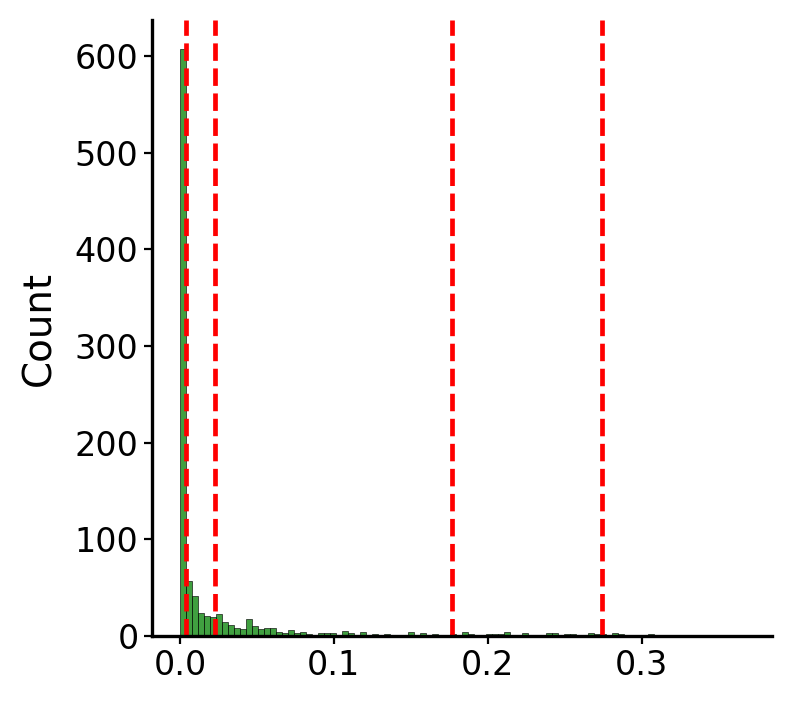

In [132]:
marker_genes = ["Neurog3", "Fev", "Ghrl", "Ins2", "Ghrl", "Sst", "Neurod2"]
metrics_marker_genes = metrics[metrics.gene_omitted.isin(marker_genes)]

sns.histplot(metrics.sink_div.values, color="green")

for i in range(len(metrics_marker_genes)):
    plt.axvline(x=metrics_marker_genes.iloc[i,:].sink_div, color='r', linestyle='--')
    
plt.show()

In [148]:
metrics_marker_genes 



,gene_omitted,sink_div,rank
0,Neurog3,0.176787,947.0
0,Neurod2,0.004195,614.0
0,Fev,0.022777,764.0
0,Sst,0.274392,987.0


In [135]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [139]:
metrics.iloc[-5:]

,gene_omitted,sink_div,rank
0,Runx1,1.958013e-05,255.0
0,Thrb,3.558263e-03,601.0
0,Gm12153,2.980232e-08,123.0
0,Gm15873,2.980232e-08,123.0
0,Negr1,3.511310e-04,419.0


/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


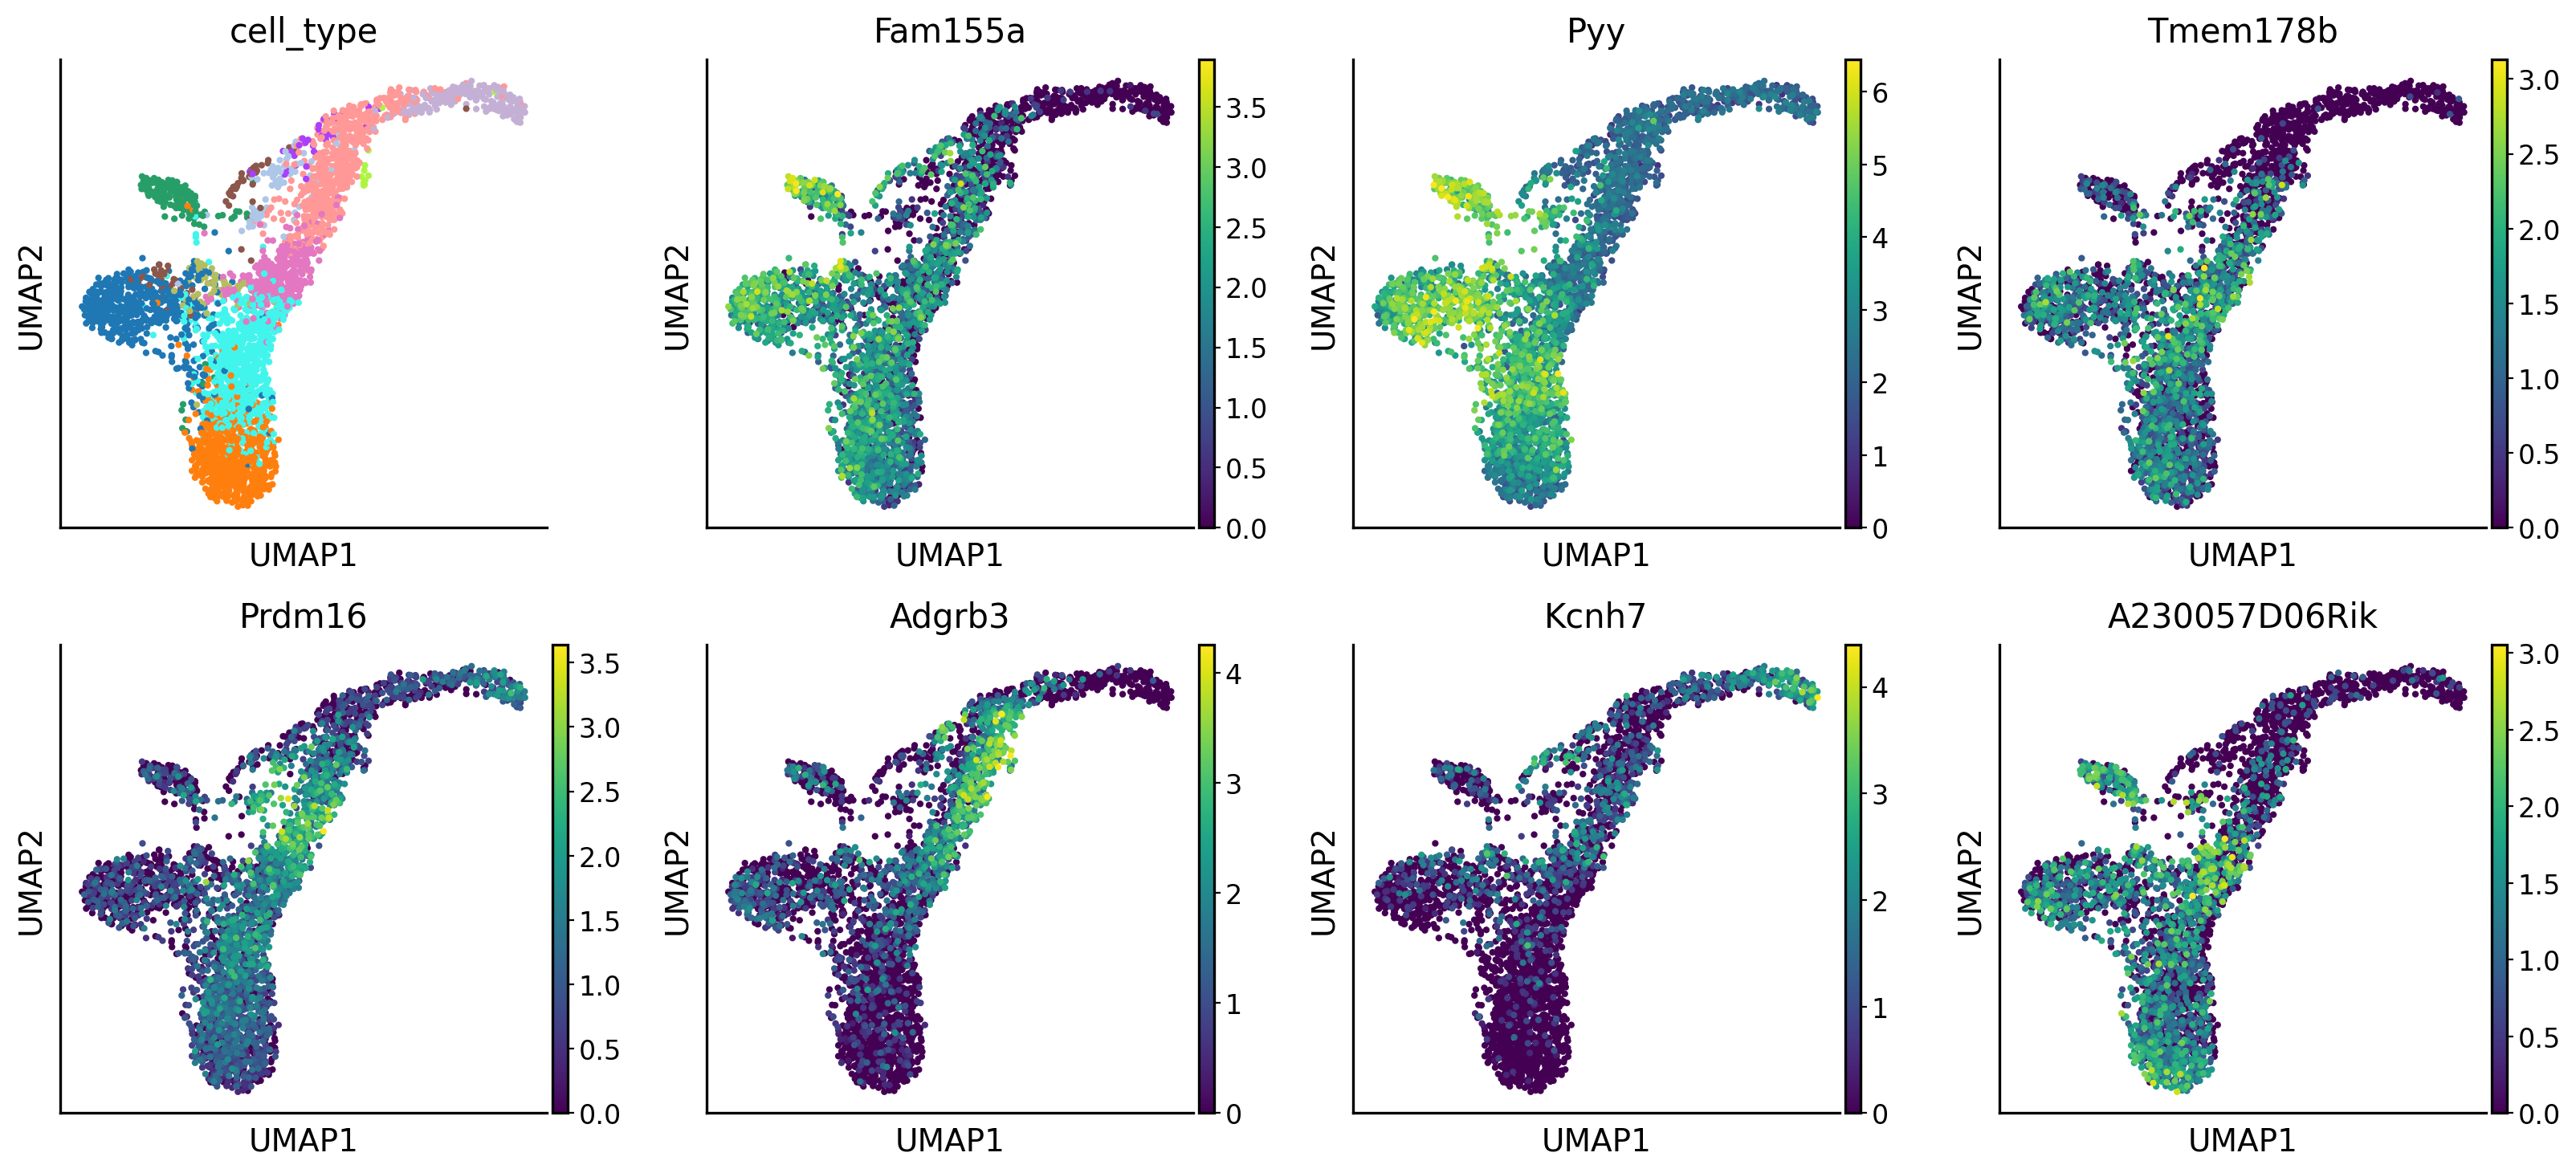

In [145]:
sc.pl.umap(adata, color=["cell_type"]+list(metrics.sort_values("sink_div").iloc[-7:]["gene_omitted"]),legend_loc=None)